## Detailed Marketing: Cohort, Pareto, RFM, Forecast

<a id='section-top'></a>
# Table Of Contents
* .[Introduction](#section-intro)

* .[1. General Infos & Playing with Features](#section-one)

*  .[2. Cohort Analysis](#section-two)
    - [2.1 Retention Rate](#section-two-one)
    
*  .[3. Pareto Principle](#section-three)
    - [3.1 Pareto Chart For Customers](#section-three-one)
    - [3.2 Pareto Chart For Products](#section-three-two)
    
* .[4. RFM Analysis](#section-tree)
    - [4.1 Preparing RFM Table](#section-four-one)
    - [4.2 RFM Segments](#section-four-two)
    - [4.3 Visualizing RFM Grid](#section-four-three)
    - [4.4 Customer Segmentation With Using RFM Metrics](#section-four-five)
    
* [5. Forecasting With prophet](#section-five)
    - [5.1 Data Preparation For Time Series](#section-five-one)
        - [5.1.1 Weekly](#section-five-one-one)
        - [5.1.2 Daily](#section-five-one-two)
     - [5.2 Stationarity](#section-five-two)
         - [5.2.1 Augmented Dickey-Fuller Test](#section-five-two-one)
     - [5.3. Seasonality, Decomposition](#section-five-three)
     - [5.4 Modeling](#section-five-four)
         - [5.4.1. Simple Model](#section-five-four-two)
         - [5.4.2. Prophet's parameters](#section-five-fpur-two)
         - [5.4.3. Forecasting Future](#section-five-four-three)
         
* [Resource, Readings](#section-zero)
* [Conclusion](#section-conlution)

**First version : 14.8.2021**

**Last Edit: 5.10.2023**

<a id="section-intro"></a>

# Introduction

This is Online Retail dataset from UCI Machine Learning Repository. It contains transactions from 2010 and 2011.

For other datasets from UCI ML https://archive.ics.uci.edu/ml/datasets.php

This is my first work about marketing. I have finished Datacamp's marketing course for a long time ago, but didn't practise it.

I prepare this notebook for practising all these stuff.

This is my full work, I also separate it into chapters. You can take a look to chapters individually.

https://www.kaggle.com/mustafacicek/online-retail-part-i-preparing-getting-insights

https://www.kaggle.com/mustafacicek/marketing-analytics-cohort-analysis

https://www.kaggle.com/mustafacicek/marketing-analytics-pareto-principle

https://www.kaggle.com/mustafacicek/marketing-analytics-rfm-analysis

https://www.kaggle.com/mustafacicek/marketing-analytics-forecasting

You can reach prepared data from here https://www.kaggle.com/mustafacicek/online-retail-final

<a id="section-zero"></a>

# Resources, Readings

Datacamp's https://www.datacamp.com/courses/customer-segmentation-in-python course

https://www.kaggle.com/allunia/e-commerce-sales-forecast I inspired some parts in analysing features.

https://www.kaggle.com/fabiendaniel/customer-segmentation It is also exciting notebook, probably you have already looked.

Basic readings about concept:

https://clevertap.com/blog/cohort-analysis/

https://en.wikipedia.org/wiki/Pareto_principle

https://www.investopedia.com/terms/p/paretoprinciple.asp

https://clevertap.com/blog/rfm-analysis/

https://www.wigzo.com/blog/rfm-analysis-for-ecommerce/

https://www.investopedia.com/terms/r/rfm-recency-frequency-monetary-value.asp

https://futurice.com/blog/know-your-customers-with-rfm

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
from matplotlib.ticker import PercentFormatter
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from itertools import combinations
from datetime import datetime
import statsmodels.api as sm
import warnings 
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from prophet import Prophet
from sklearn.metrics import r2_score, mean_squared_error

pd.options.mode.chained_assignment = None

plt.rcParams['axes.facecolor'] = "#A2A2A2"
plt.rcParams['axes.grid'] =1

<a id='section-one'></a>

# 1) General Infos & Playing With Features

In [2]:
df = pd.read_csv("D:\\IBM_Data_Science\\Data_set\\Data_Kagle_Github\\OnlineRetail.csv",encoding = 'unicode_escape')
display(df.head())
print(df.shape)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


(541909, 8)


**Check information of data frame**

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   InvoiceNo    541909 non-null  object 
 1   StockCode    541909 non-null  object 
 2   Description  540455 non-null  object 
 3   Quantity     541909 non-null  int64  
 4   InvoiceDate  541909 non-null  object 
 5   UnitPrice    541909 non-null  float64
 6   CustomerID   406829 non-null  float64
 7   Country      541909 non-null  object 
dtypes: float64(2), int64(1), object(5)
memory usage: 33.1+ MB


- We have missing values for column Description and CustomerID. Go deeper

In [4]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [5]:
df[df.Description.isnull()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
622,536414,22139,NaN,56,12/1/2010 11:52,0.0,NaN,United Kingdom
1970,536545,21134,NaN,1,12/1/2010 14:32,0.0,NaN,United Kingdom
1971,536546,22145,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1972,536547,37509,NaN,1,12/1/2010 14:33,0.0,NaN,United Kingdom
1987,536549,85226A,NaN,1,12/1/2010 14:34,0.0,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
535322,581199,84581,NaN,-2,12/7/2011 18:26,0.0,NaN,United Kingdom
535326,581203,23406,NaN,15,12/7/2011 18:31,0.0,NaN,United Kingdom
535332,581209,21620,NaN,6,12/7/2011 18:35,0.0,NaN,United Kingdom
536981,581234,72817,NaN,27,12/8/2011 10:33,0.0,NaN,United Kingdom


- When desription is null, we have 0 unit price and missing customer ids. Let's check for whole data.

In [6]:
df[df.Description.isnull()].CustomerID.nunique()

0

In [7]:
df[df.Description.isnull()].UnitPrice.value_counts()

0.0    1454
Name: UnitPrice, dtype: int64

- When desription is null, we have no available customer and zero unit price for all data. Let's drop nan values.

In [8]:
df = df[df.Description.notnull()]

In [9]:
df[df.CustomerID.isnull()]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
1443,536544,21773,DECORATIVE ROSE BATHROOM BOTTLE,1,12/1/2010 14:32,2.51,NaN,United Kingdom
1444,536544,21774,DECORATIVE CATS BATHROOM BOTTLE,2,12/1/2010 14:32,2.51,NaN,United Kingdom
1445,536544,21786,POLKADOT RAIN HAT,4,12/1/2010 14:32,0.85,NaN,United Kingdom
1446,536544,21787,RAIN PONCHO RETROSPOT,2,12/1/2010 14:32,1.66,NaN,United Kingdom
1447,536544,21790,VINTAGE SNAP CARDS,9,12/1/2010 14:32,1.66,NaN,United Kingdom
...,...,...,...,...,...,...,...,...
541536,581498,85099B,JUMBO BAG RED RETROSPOT,5,12/9/2011 10:26,4.13,NaN,United Kingdom
541537,581498,85099C,JUMBO BAG BAROQUE BLACK WHITE,4,12/9/2011 10:26,4.13,NaN,United Kingdom
541538,581498,85150,LADIES & GENTLEMEN METAL SIGN,1,12/9/2011 10:26,4.96,NaN,United Kingdom
541539,581498,85174,S/4 CACTI CANDLES,1,12/9/2011 10:26,10.79,NaN,United Kingdom


At first look, we can see reocords that have mssing customer id, there is no specified charecterics.
StockCode contains non-numeric i,e DOT,it is a cue for examining stock codes.

In [10]:
print("We have {} observations.".format(df.shape[0]))

df = df[df.CustomerID.notnull()]
print("We have {} observations after removing unknow customers". format(df.shape[0]))

We have 540455 observations.
We have 406829 observations after removing unknow customers


In [11]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

- We are done with values are filred with some denotations. "NAN", 'na', "Unknown". and spo on. Let's check them.

In [12]:
df[df.Description.str.len() < 5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country


In [13]:
df.InvoiceNo.value_counts()

576339    542
579196    533
580727    529
578270    442
573576    435
         ... 
554155      1
570248      1
545414      1
545418      1
565192      1
Name: InvoiceNo, Length: 22190, dtype: int64

In [14]:
df[df['InvoiceNo'].str.startswith('C')]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom
...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,12/9/2011 9:57,0.83,14397.0,United Kingdom
541541,C581499,M,Manual,-1,12/9/2011 10:28,224.69,15498.0,United Kingdom
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,12/9/2011 11:57,10.95,15311.0,United Kingdom
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,12/9/2011 11:58,1.25,17315.0,United Kingdom


- Cancelled invoices have negative quantity

In [15]:
df['Cancelled'] =df['InvoiceNo'].apply(lambda x:1 if x.startswith("C") else 0)

Cancel we have cancellation record, and record before cancellation. I mean, for example, we have C536379, have we 53679?

In [16]:
cancelled_invoiceNo = df[df.Cancelled == 1].InvoiceNo.tolist()
cancelled_invoiceNo = [x[1:] for x in cancelled_invoiceNo]

cancelled_invoiceNo[:5]

['536379', '536383', '536391', '536391', '536391']

In [17]:
df[df['InvoiceNo'].isin(cancelled_invoiceNo)]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled


Nothing , we have just cancellation.

Well, may be we have different pattern about InvoiceNo. Let's check it.

In [18]:
df[df.InvoiceNo.str.len() !=6 ]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled
141,C536379,D,Discount,-1,12/1/2010 9:41,27.50,14527.0,United Kingdom,1
154,C536383,35004C,SET OF 3 COLOURED FLYING DUCKS,-1,12/1/2010 9:49,4.65,15311.0,United Kingdom,1
235,C536391,22556,PLASTERS IN TIN CIRCUS PARADE,-12,12/1/2010 10:24,1.65,17548.0,United Kingdom,1
236,C536391,21984,PACK OF 12 PINK PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom,1
237,C536391,21983,PACK OF 12 BLUE PAISLEY TISSUES,-24,12/1/2010 10:24,0.29,17548.0,United Kingdom,1
...,...,...,...,...,...,...,...,...,...
540449,C581490,23144,ZINC T-LIGHT HOLDER STARS SMALL,-11,12/9/2011 9:57,0.83,14397.0,United Kingdom,1
541541,C581499,M,Manual,-1,12/9/2011 10:28,224.69,15498.0,United Kingdom,1
541715,C581568,21258,VICTORIAN SEWING BOX LARGE,-5,12/9/2011 11:57,10.95,15311.0,United Kingdom,1
541716,C581569,84978,HANGING HEART JAR T-LIGHT HOLDER,-1,12/9/2011 11:58,1.25,17315.0,United Kingdom,1


No, we only have proper invoices cancellations for InvoiceNo. We don't have any different pattern.

In [19]:
df = df[df.Cancelled ==0]


Stock Codes generally ciontrains 5 digit numerical codes.

In [20]:
df[df.StockCode.str.contains("^[a-zA-Z]")].StockCode.value_counts()

POST            1099
M                290
C2               133
DOT               16
BANK CHARGES      12
PADS               4
Name: StockCode, dtype: int64

In [21]:
df[df.StockCode.str.contains("^[a-zA-Z]")].Description.value_counts()

POSTAGE                       1099
Manual                         290
CARRIAGE                       133
DOTCOM POSTAGE                  16
Bank Charges                    12
PADS TO MATCH ALL CUSHIONS       4
Name: Description, dtype: int64

- It looks like data contain more than customer transactions. I will drop them.


In [22]:
df[df.StockCode.str.len() > 5].StockCode.value_counts()

85123A    2035
85099B    1618
82494L     820
85099F     664
85099C     659
          ... 
35610C       1
90187B       1
90190A       1
90190B       1
90214Z       1
Name: StockCode, Length: 875, dtype: int64

In [23]:
df[df.StockCode.str.len() > 5].Description.value_counts()

WHITE HANGING HEART T-LIGHT HOLDER     2028
JUMBO BAG RED RETROSPOT                1618
WOODEN FRAME ANTIQUE WHITE              820
JUMBO BAG STRAWBERRY                    664
JUMBO  BAG BAROQUE BLACK WHITE          659
                                       ... 
PURPLE/BLUE CERAMIC CANDLE HOLDER         1
ORANGE PENDANT TRIPLE SHELL NECKLAC       1
ROSE PENDANT TRIPLE SHELL NECKLACE        1
BLACK CHRISTMAS FLOCK DROPLET             1
CURIOUS IMAGES SCRAP BOOK SET             1
Name: Description, Length: 887, dtype: int64

 Some stock codes have a letter at the and of their codes. I don't know what they refers so I will keep them.

In [24]:
df = df[~ df.StockCode.str.contains("a-zA-Z")]

In [25]:
df['Description'] = df['Description'].str.lower()

I just standard desciptions with converting them to all lowercase charaterics.

- Stock Codes -Description

In [26]:
df.groupby("StockCode")["Description"].nunique()[df.groupby("StockCode")["Description"].nunique() != 1]

StockCode
16156L    2
17107D    3
20622     2
20725     2
20914     2
         ..
85184C    2
85185B    2
90014A    2
90014B    2
90014C    2
Name: Description, Length: 213, dtype: int64

213 Stock codes have nore than one description . Let's check some of them.

In [27]:
df[df.StockCode == '16156L'].Description.value_counts()

wrap carousel     14
wrap, carousel     4
Name: Description, dtype: int64

In [28]:
df[df.StockCode == '17107D'].Description.value_counts()

flower fairy,5 summer b'draw liners    25
flower fairy 5 drawer liners           21
flower fairy 5 summer draw liners       1
Name: Description, dtype: int64

In [29]:
df[df.StockCode == '90014C'].Description.value_counts()

silver/black orbit necklace        2
silver and black orbit necklace    1
Name: Description, dtype: int64

- Seens we have just a litle differences t=between them i.e "," or '/'

In [30]:
df.CustomerID.value_counts()

17841.0    7847
14911.0    5677
14096.0    5111
12748.0    4596
14606.0    2700
           ... 
15313.0       1
17846.0       1
13185.0       1
16953.0       1
16737.0       1
Name: CustomerID, Length: 4339, dtype: int64

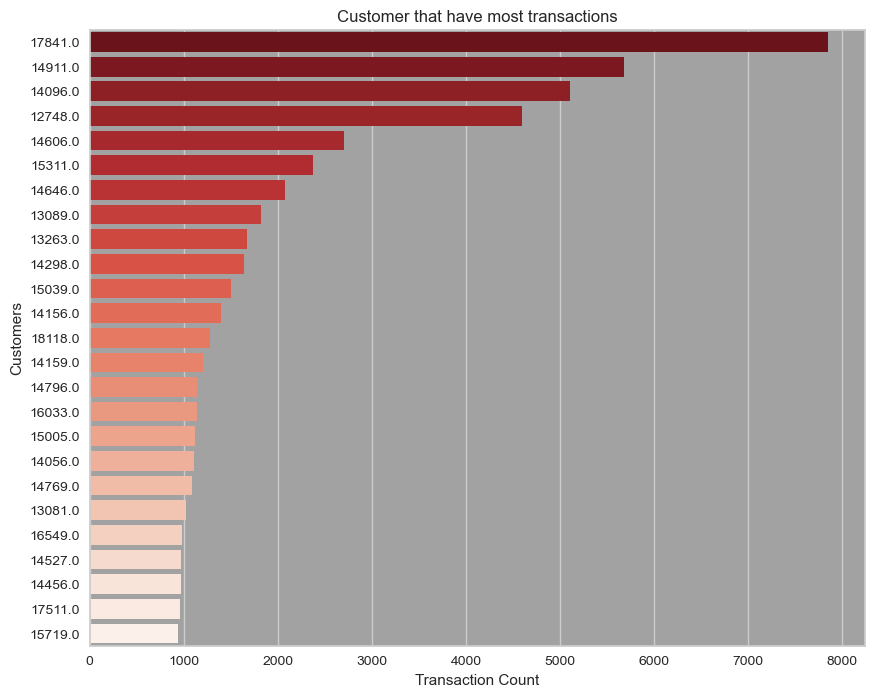

In [31]:
customer_counts = df.CustomerID.value_counts().sort_values(ascending =False).head(25)
fig, ax = plt.subplots(figsize =(10,8))

sns.barplot( y =customer_counts.index, x =customer_counts.values, orient ='h',
            ax =ax, order = customer_counts.index, palette = 'Reds_r')
plt.title("Customer that have most transactions")
plt.ylabel("Customers")
plt.xlabel("Transaction Count")

plt.show()


In [32]:
df.Country.value_counts()

United Kingdom          354345
Germany                   9042
France                    8342
EIRE                      7238
Spain                     2485
Netherlands               2363
Belgium                   2031
Switzerland               1842
Portugal                  1462
Australia                 1185
Norway                    1072
Italy                      758
Channel Islands            748
Finland                    685
Cyprus                     614
Sweden                     451
Austria                    398
Denmark                    380
Poland                     330
Japan                      321
Israel                     248
Unspecified                244
Singapore                  222
Iceland                    182
USA                        179
Canada                     151
Greece                     145
Malta                      112
United Arab Emirates        68
European Community          60
RSA                         58
Lebanon                     45
Lithuani

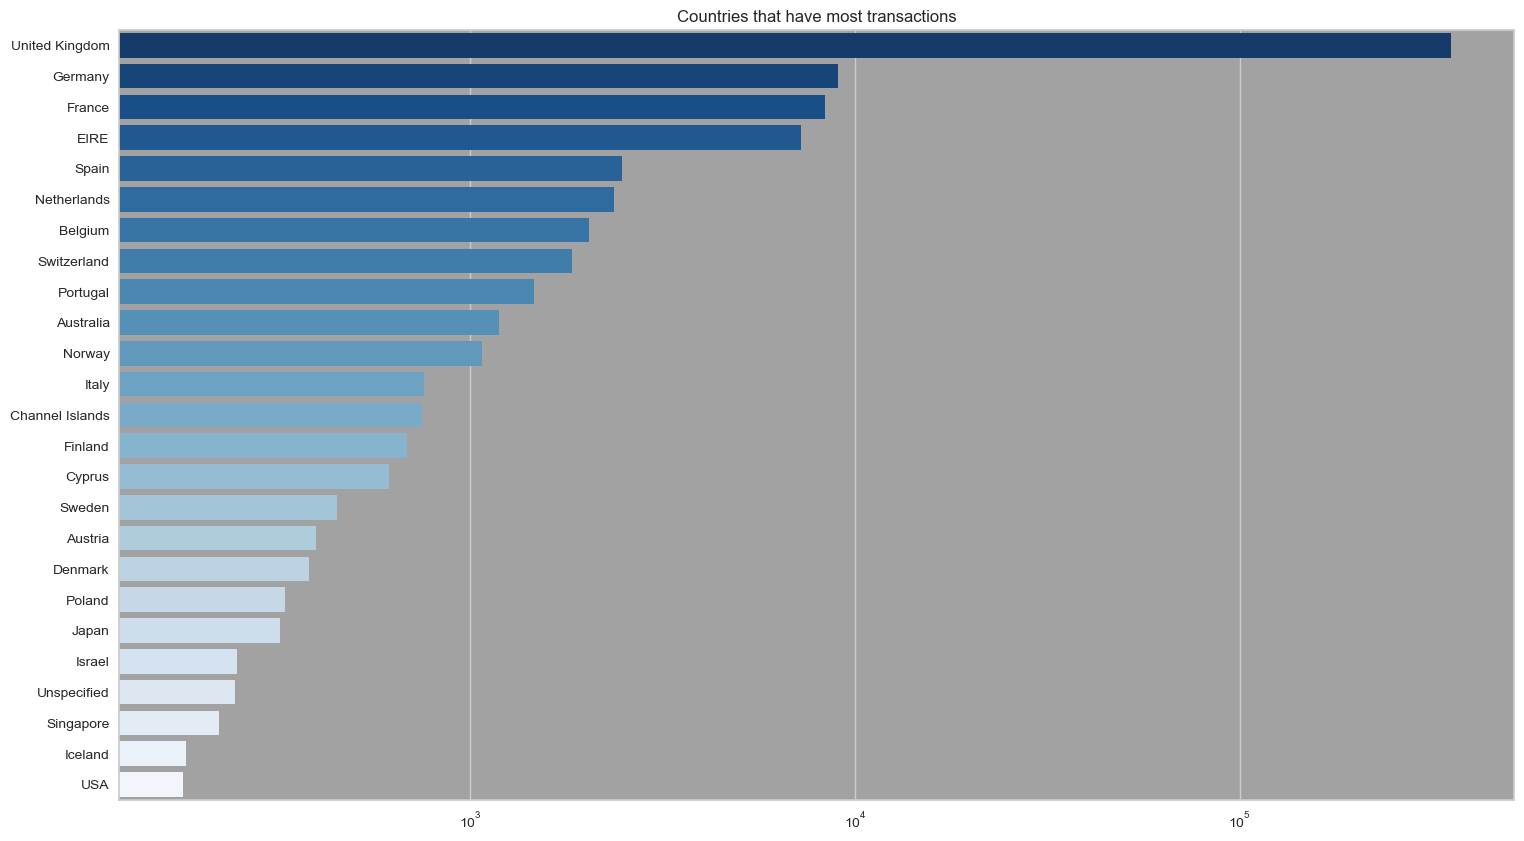

In [33]:
country_counts = df.Country.value_counts().sort_values(ascending=False).head(25)

fig, ax = plt.subplots(figsize = (18, 10))

sns.barplot(x = country_counts.values, y = country_counts.index, orient = "h", 
            ax = ax, order = country_counts.index, palette = "Blues_r")
plt.title("Countries that have most transactions")
plt.xscale("log")
plt.show()

In [34]:
df['UnitPrice'].describe()

count    397924.000000
mean          3.116174
std          22.096788
min           0.000000
25%           1.250000
50%           1.950000
75%           3.750000
max        8142.750000
Name: UnitPrice, dtype: float64

0 unit price ?

In [35]:
df[df.UnitPrice == 0].head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Cancelled
9302,537197,22841,round cake tin vintage green,1,12/5/2010 14:02,0.0,12647.0,Germany,0
33576,539263,22580,advent calendar gingham sack,4,12/16/2010 14:36,0.0,16560.0,United Kingdom,0
40089,539722,22423,regency cakestand 3 tier,10,12/21/2010 13:45,0.0,14911.0,EIRE,0
47068,540372,22090,paper bunting retrospot,24,1/6/2011 16:41,0.0,13081.0,United Kingdom,0
47070,540372,22553,plasters in tin skulls,24,1/6/2011 16:41,0.0,13081.0,United Kingdom,0


i didn't any pattern. So, I remove them.

In [36]:
print("We have {} observations".format(df.shape[0]))
df =df[df.UnitPrice >0]
print("We have {} observation safter removing records that have 0 unit price". format(df.shape[0]))

We have 397924 observations
We have 397884 observation safter removing records that have 0 unit price


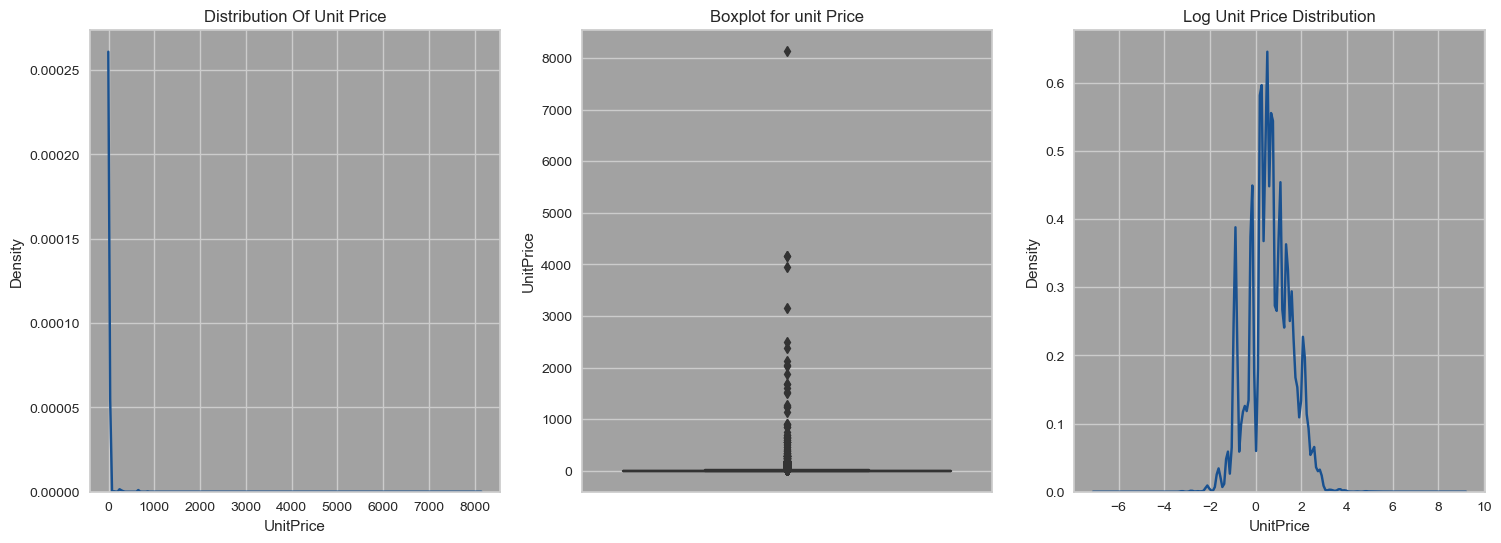

In [37]:
fig, axes = plt.subplots(1,3, figsize =(18,6))

sns.kdeplot(df['UnitPrice'], ax =axes[0], color='#195190').set_title("Distribution Of Unit Price")
sns.boxplot(y = df['UnitPrice'], ax =axes[1], color ='#195190').set_title("Boxplot for unit Price")
sns.kdeplot(np.log(df['UnitPrice']), ax =axes[2], color ="#195190").set_title("Log Unit Price Distribution")

plt.show()

In [38]:
print("Lower limit for UnitPrice:" + str(np.exp(-2)))
print("Upper limit for Unitprice: "+ str(np.exp(3)))

Lower limit for UnitPrice:0.1353352832366127
Upper limit for Unitprice: 20.085536923187668


In [39]:
np.quantile(df.UnitPrice, 0.99)

14.95

In [40]:
print("We have {} observations". format(df.shape[0]))

df =df[(df.UnitPrice > 0.1) & (df.UnitPrice <20)]
print("We have {} observations after removing unit prices smaller than 0.1 and greater than 20". format(df.shape[0]))

We have 397884 observations
We have 396462 observations after removing unit prices smaller than 0.1 and greater than 20


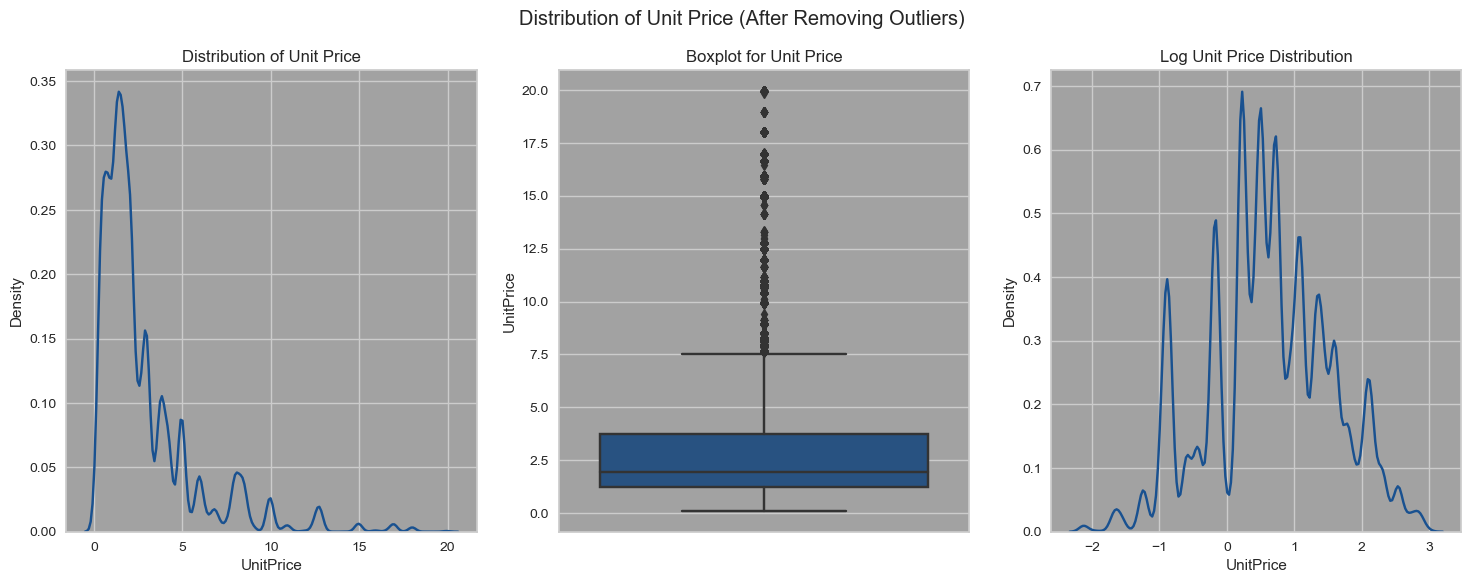

In [41]:
fig, axes = plt.subplots(1, 3, figsize = (18, 6))

sns.kdeplot(df["UnitPrice"], ax = axes[0], color = "#195190").set_title("Distribution of Unit Price")
sns.boxplot(y = df["UnitPrice"], ax = axes[1], color = "#195190").set_title("Boxplot for Unit Price")
sns.kdeplot(np.log(df["UnitPrice"]), ax = axes[2], color = "#195190").set_title("Log Unit Price Distribution")

fig.suptitle("Distribution of Unit Price (After Removing Outliers)")
plt.show()

In [42]:
df['Quantity'].describe()

count    396462.000000
mean         12.933943
std         179.461050
min           1.000000
25%           2.000000
50%           6.000000
75%          12.000000
max       80995.000000
Name: Quantity, dtype: float64

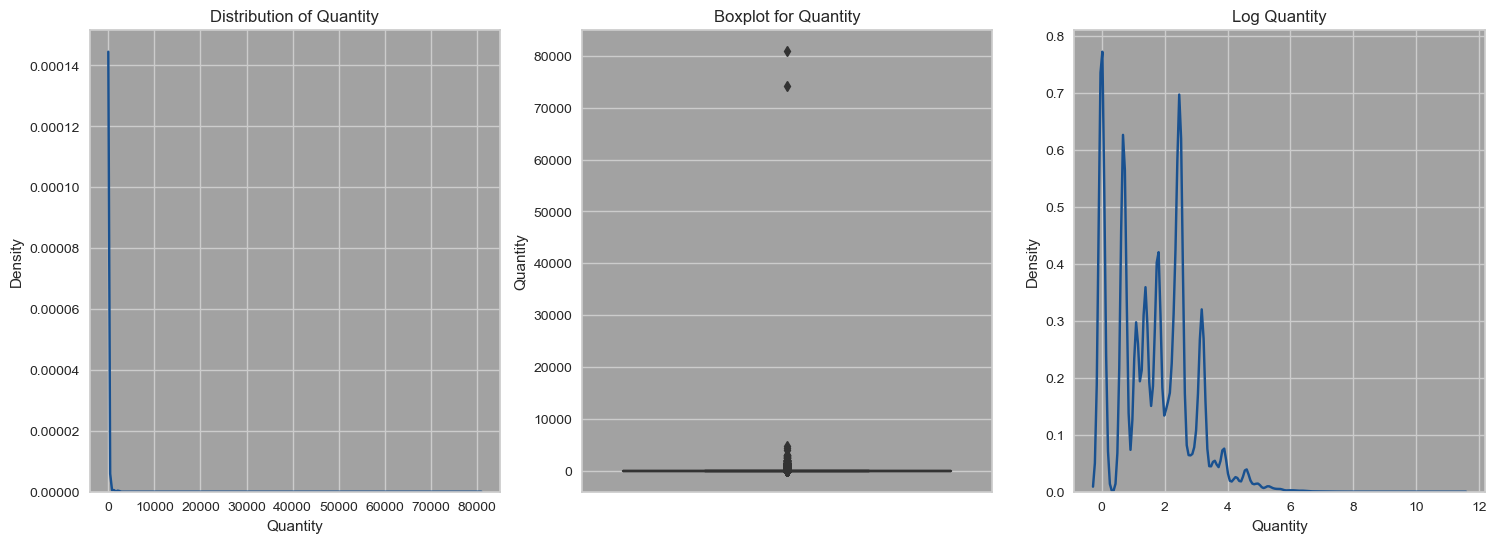

In [43]:
fig, axes = plt.subplots(1, 3, figsize = (18, 6))

sns.kdeplot(df["Quantity"], ax = axes[0], color = "#195190").set_title("Distribution of Quantity")
sns.boxplot(y = df["Quantity"], ax = axes[1], color = "#195190").set_title("Boxplot for Quantity")
sns.kdeplot(np.log(df["Quantity"]), ax = axes[2], color = "#195190").set_title("Log Quantity")
plt.show()

In [44]:
print("Upper limit for Quantity:"+ str(np.exp(5)))

Upper limit for Quantity:148.4131591025766


In [45]:
np.quantile(df.Quantity, 0.99)

120.0

In [46]:
print("We have {} observations.".format(df.shape[0]))

df = df[(df.Quantity < 150)]

print("We have {} observations after removing quantities greater than 150.".format(df.shape[0]))

We have 396462 observations.
We have 393806 observations after removing quantities greater than 150.


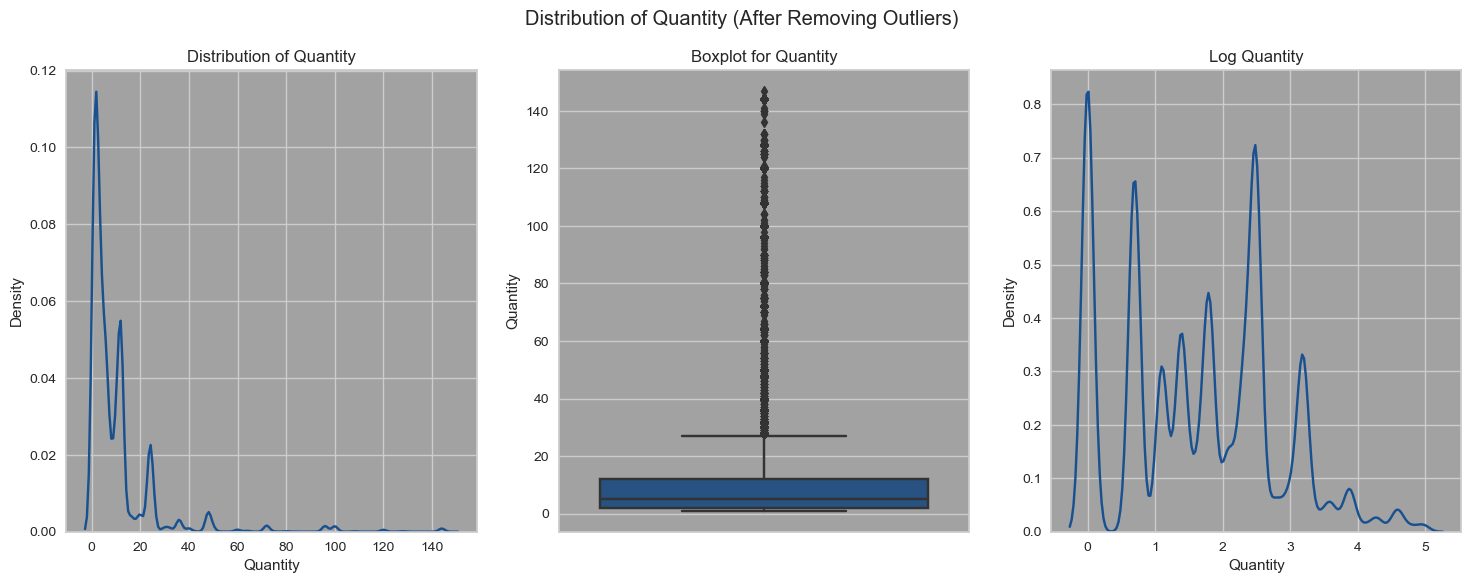

In [47]:
fig, axes = plt.subplots(1, 3, figsize = (18, 6))

sns.kdeplot(df["Quantity"], ax = axes[0], color = "#195190").set_title("Distribution of Quantity")
sns.boxplot(y = df["Quantity"], ax = axes[1], color = "#195190").set_title("Boxplot for Quantity")
sns.kdeplot(np.log(df["Quantity"]), ax = axes[2], color = "#195190").set_title("Log Quantity")

fig.suptitle("Distribution of Quantity (After Removing Outliers)")
plt.show()

In [48]:
df['TotalPrice'] = df['Quantity']*df['UnitPrice']
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

In [49]:
df.drop('Cancelled', axis =1, inplace =True)
df.to_csv("Online_retail_final.csv", index =False)

Take me to the top

<a id ='section-two'></a>

# 2) Cohort Analysis

A cohort simply means that a group of people they have same characteristics.

Generally, we have three type of cohort analysis:

   - **Time cohorts** or **Acquisition cohorts**: Groups are divided by first activity.
   - **Behavior cohorts** or **Segment-Based cohorts**: Groups are divided by their behaivors and actions about your service.
   - **Size cohorts**: Size-based cohorts refer to the various sizes of customers who purchase a company’s products or services.


Cohort analysis is a subset of behavioral analytics that takes the data from a given eCommerce platform, web application, or online game and rather than looking at all users as one unit, it breaks them into related groups for analysis. These related groups, or cohorts, usually share common characteristics or experiences within a defined time-span.

Cohort analysis is a tool to measure user engagement over time. It helps to know whether user engagement is actually getting better over time or is only appearing to improve because of growth.

Cohort analysis proves to be valuable because it helps to separate growth metrics from engagement metrics as growth can easily mask engagement problems. In reality, the lack of activity of the old users is being hidden by the impressive growth numbers of new users, which results in concealing the lack of engagement from a small number of people.

*https://clevertap.com/blog/cohort-analysis/

Cohort analysis is a better way of looking at data. Its application is not limited to a single industry or function. For example, eCommerce companies can use cohort analysis to spot products that have more potential for sales growth. In digital marketing, it can help identify web pages that perform well based on time spent on websites, conversions or sign-ups. In product marketing, this analysis can be used to identify the success of feature adoption rate and also to reduce churn rates.

*https://www.moengage.com/blog/growth-tactic-1-how-to-use-cohort-analysis-to-measure-customer-retention/

In [50]:
print("Min date: {} \nMax date: {}".format(df.InvoiceDate.min(), df.InvoiceDate.max()))
print("Time difference is: {}".format(df.InvoiceDate.max() - df.InvoiceDate.min()))

Min date: 2010-12-01 08:26:00 
Max date: 2011-12-09 12:50:00
Time difference is: 373 days 04:24:00


Our dataset contains invoice records for more than one year. Let's apply cohort analysis. We can create monthly cohorts.

We will group customers for first invoice record. Cohort index will be number of months since first transaction.

In [51]:
def get_month(x): return dt.datetime(x.year, x.month,1)

def get_dates(df,col):
    
    year = df[col].dt.year
    month = df[col].dt.month
    day = df[col].dt.day
    
    return year, month, day

In [52]:
df['InvoiceMonth'] = df['InvoiceDate'].apply(get_month)

df['CohortMonth'] = df.groupby('CustomerID')['InvoiceMonth'].transform('min')


In [53]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,TotalPrice,InvoiceMonth,CohortMonth
0,536365,85123A,white hanging heart t-light holder,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,2010-12-01,2010-12-01
1,536365,71053,white metal lantern,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01
2,536365,84406B,cream cupid hearts coat hanger,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00,2010-12-01,2010-12-01
3,536365,84029G,knitted union flag hot water bottle,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01
4,536365,84029E,red woolly hottie white heart.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,2010-12-01,2010-12-01


In [54]:
invoice_year, invoice_month, invoice_day = get_dates(df, 'InvoiceMonth')
cohort_year, cohort_month, cohort_day = get_dates(df, "CohortMonth")

year_diff = invoice_year -cohort_year
month_diff = invoice_month -cohort_month

df['CohortIndex'] = 12*year_diff + month_diff +1

In [55]:
cohort_data = df.groupby(['CohortIndex', 'CohortMonth'])['CustomerID'].nunique().reset_index()
cohort_pivot = cohort_data.pivot(index ='CohortMonth', columns = 'CohortIndex',values = "CustomerID" )

cohort_pivot

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12-01,875.0,320.0,280.0,330.0,317.0,350.0,316.0,303.0,304.0,346.0,327.0,441.0,232.0
2011-01-01,411.0,92.0,112.0,94.0,133.0,120.0,103.0,102.0,125.0,135.0,151.0,48.0,NaN
2011-02-01,375.0,68.0,69.0,103.0,100.0,91.0,93.0,101.0,92.0,115.0,25.0,NaN,NaN
2011-03-01,450.0,66.0,111.0,90.0,101.0,75.0,119.0,104.0,124.0,38.0,NaN,NaN,NaN
2011-04-01,297.0,64.0,61.0,61.0,56.0,68.0,65.0,77.0,22.0,NaN,NaN,NaN,NaN
2011-05-01,279.0,54.0,48.0,48.0,59.0,65.0,75.0,26.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,240.0,42.0,38.0,64.0,54.0,78.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,189.0,35.0,39.0,42.0,50.0,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,170.0,34.0,42.0,41.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Above data is our cohort table. Its interpretation is simple. For example, We have 874 unique customer with their first transaction is in 2010-12. Its cohort month is 2010-12 and cohort index is 1. Go on the one right cell, it is 319. Its mean, 319 unique customer retain their customership for next month.

<a id="section-two-one"></a>

# 2.1) Retention Rate

![](https://images.ctfassets.net/vrkkgjbn4fsk/7KUaWGQ9IJvf85OheLucgk/e03a27e5c68cc317b38dda354fee504d/how_to_calculate_user_retention_rate)

*https://amplitude.com/blog/how-to-calculate-retention-rate-b2b-saas

Retention tables show a group of people that visited your site or used your app for the first time during a certain time frame. They also display the progressive ‘drop-off’ or decline in activity over time for that particular group (a cohort).

Marketers can use Retention tables to analyze the quality of users brought by a marketing campaign and compare it to other sources of traffic.

*https://www.smartlook.com/blog/retention-tables-introduction/

In [56]:
cohort_sizes =cohort_pivot.iloc[:, 0]

retention = cohort_pivot.divide(cohort_sizes, axis =0)
retention.index = retention.index.strftime("%Y-%m")

retention

CohortIndex,1,2,3,4,5,6,7,8,9,10,11,12,13
CohortMonth,,,,,,,,,,,,,
2010-12,1.0,0.365714,0.320000,0.377143,0.362286,0.400000,0.361143,0.346286,0.347429,0.395429,0.373714,0.504000,0.265143
2011-01,1.0,0.223844,0.272506,0.228710,0.323601,0.291971,0.250608,0.248175,0.304136,0.328467,0.367397,0.116788,NaN
2011-02,1.0,0.181333,0.184000,0.274667,0.266667,0.242667,0.248000,0.269333,0.245333,0.306667,0.066667,NaN,NaN
2011-03,1.0,0.146667,0.246667,0.200000,0.224444,0.166667,0.264444,0.231111,0.275556,0.084444,NaN,NaN,NaN
2011-04,1.0,0.215488,0.205387,0.205387,0.188552,0.228956,0.218855,0.259259,0.074074,NaN,NaN,NaN,NaN
2011-05,1.0,0.193548,0.172043,0.172043,0.211470,0.232975,0.268817,0.093190,NaN,NaN,NaN,NaN,NaN
2011-06,1.0,0.175000,0.158333,0.266667,0.225000,0.325000,0.095833,NaN,NaN,NaN,NaN,NaN,NaN
2011-07,1.0,0.185185,0.206349,0.222222,0.264550,0.111111,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08,1.0,0.200000,0.247059,0.241176,0.129412,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


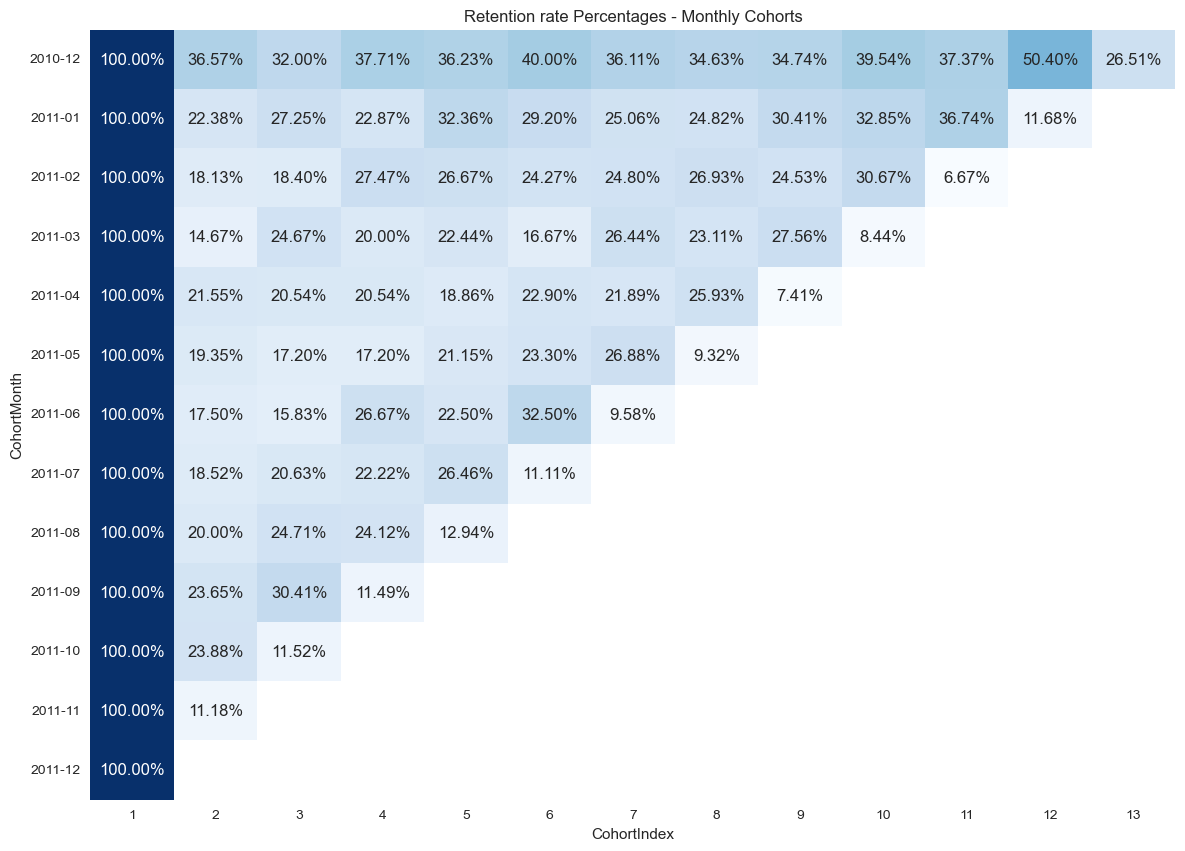

In [57]:
plt.rcParams['axes.facecolor'] = 'white'
fig, ax =plt.subplots(figsize =(14,10))

sns.heatmap(retention, cmap ='Blues', annot = True, fmt =".2%", annot_kws ={'fontsize': 12}, cbar = False, ax =ax)

plt.title("Retention rate Percentages - Monthly Cohorts")
plt.yticks(rotation = 0)
plt.show()

In [58]:
customer_per_month =df.groupby("CohortMonth")['CustomerID'].nunique().values
customers =customer_per_month.cumsum()
customers =customers[::-1]
customers 

array([4299, 4260, 3938, 3582, 3286, 3116, 2927, 2687, 2408, 2111, 1661,
       1286,  875], dtype=int64)

In [59]:
customer_in_month =df.groupby('CohortIndex')['CustomerID'].nunique()
customer_in_month

CohortIndex
1     4299
2      966
3      931
4      907
5      892
6      868
7      794
8      713
9      667
10     634
11     503
12     489
13     232
Name: CustomerID, dtype: int64

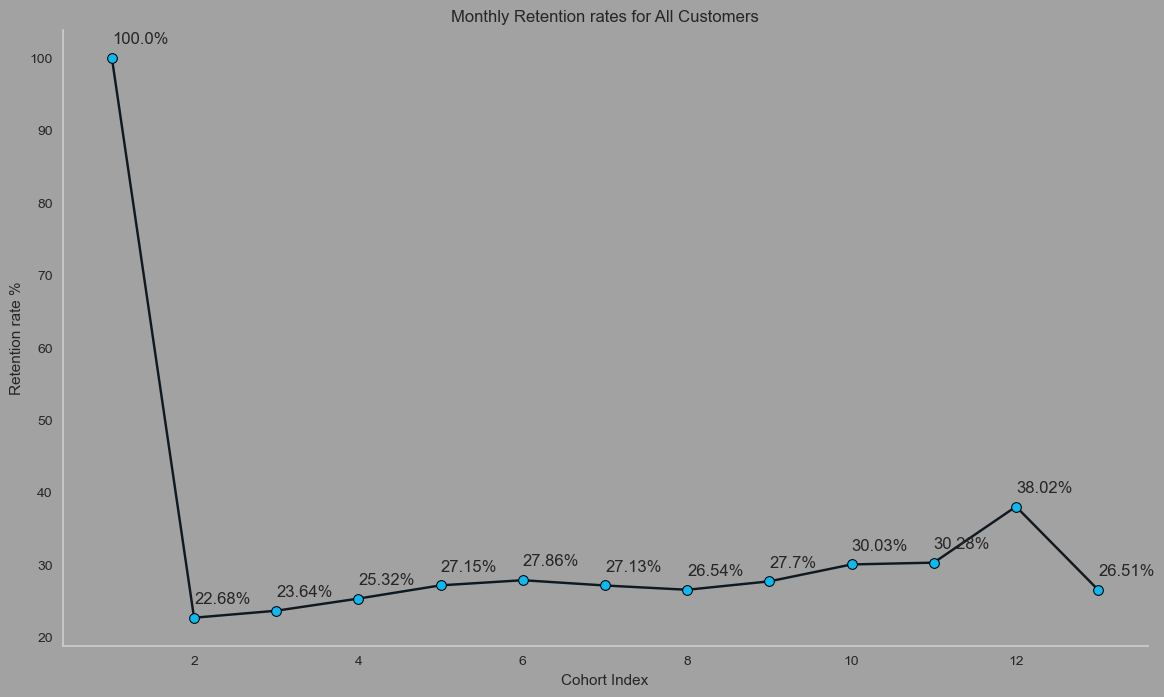

In [60]:
plt.rcParams['axes.facecolor'] = '#A2A2A2'
fig, ax =plt.subplots(figsize =(14,8), facecolor ="#A2A2A2")
ax.grid(False)
x =customer_in_month.index
y = 100*(customer_in_month/customers)

sns.lineplot( x =x, y =y, color ='#101820', marker ='o', markerfacecolor ='#0EB8F1', markeredgecolor = '#000000')

for x,y in zip(x,y):
    plt.text(x,y +2, s = str(round(y,2))+"%")
    
plt.xlabel("Cohort Index")
plt.ylabel('Retention rate %')
plt.title("Monthly Retention rates for All Customers")
sns.despine()
plt.show()

**Retention rate increases significantly for last months of the year.**

Probably, Thankssgiving, Black friday and Christmas causes it . There are lots of special day at the of year.

In [61]:
monthly_customer_price_df = df.groupby("InvoiceMonth").agg({"TotalPrice": "sum",
                                                            "CustomerID": "nunique"})

monthly_customer_price_df

,TotalPrice,CustomerID
InvoiceMonth,,
2010-12-01,480486.44,875
2011-01-01,406179.28,731
2011-02-01,387109.76,747
2011-03-01,504553.70,960
2011-04-01,391032.45,843
2011-05-01,582327.62,1040
2011-06-01,505424.86,981
2011-07-01,498343.72,938
2011-08-01,515613.40,921


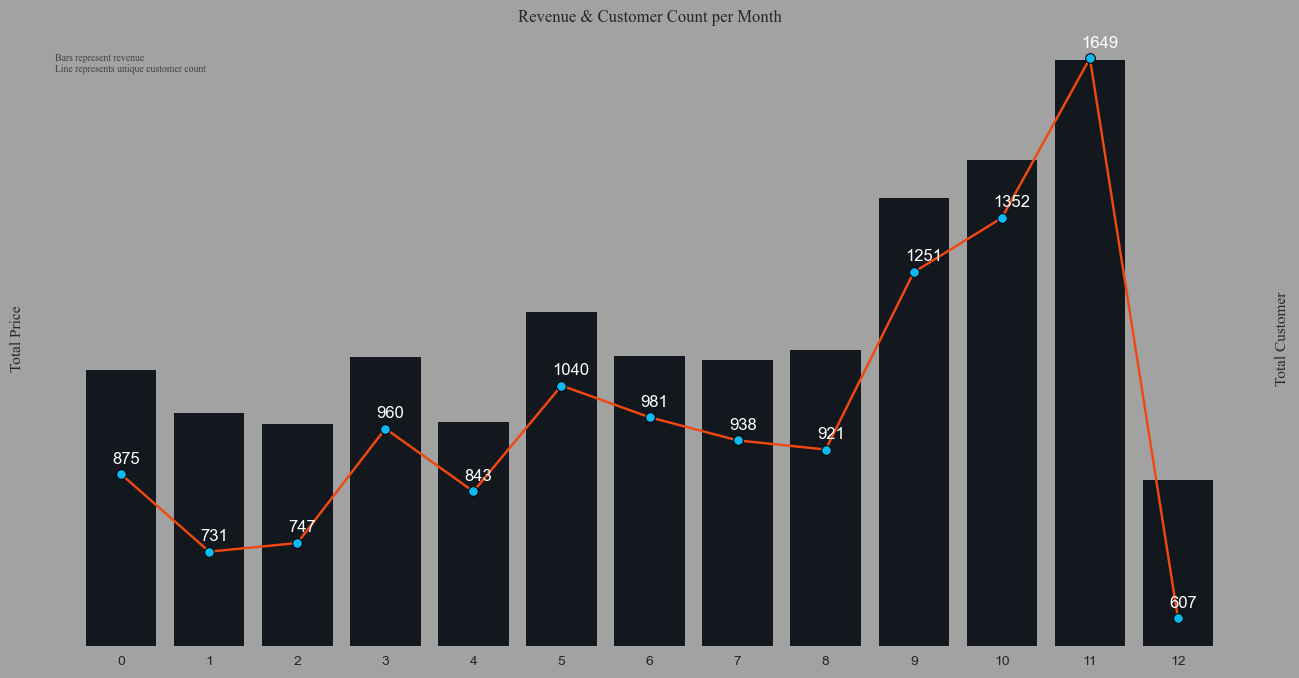

In [62]:
fig, ax = plt.subplots(figsize = (16, 8), facecolor = "#A2A2A2")
ax.set_facecolor("#A2A2A2")

sns.barplot(x = np.arange(len(monthly_customer_price_df.index)), y = monthly_customer_price_df.TotalPrice, ax = ax,
            color = "#101820")
ax2 = ax.twinx()
sns.lineplot(x = np.arange(len(monthly_customer_price_df.index)), y = monthly_customer_price_df.CustomerID, ax = ax2,
            color = "#F1480F", marker = "o", markerfacecolor = "#0EB8F1", markeredgecolor = "#000000")

ax.set_yticks([])
ax2.set_yticks([])
ax2.set_ylabel("Total Customer", fontname = "Times New Roman")
ax.set_ylabel("Total Price", fontname = "Times New Roman")
plt.title("Revenue & Customer Count per Month", fontname = "Times New Roman")
ax.text(-0.75, 1000000, "Bars represent revenue \nLine represents unique customer count", 
        fontsize = 7, alpha = 0.8, fontname = "Times New Roman")
for x, y in zip(np.arange(len(monthly_customer_price_df.index)),  monthly_customer_price_df.CustomerID):
    ax2.text(x -0.1, y + 20 , y, color = "white")
    
sns.despine(left = True, right = True, bottom = True, top = True)
plt.show()

<a id='section-three'></a>

# 3) Pareto Principle

The Pareto principle states that for many outcomes, roughly 80% of consequences come from 20% of causes (the “vital few”).

Other names for this principle are the 80/20 rule, the law of the vital few, or the principle of factor sparsity.

![](https://upload.wikimedia.org/wikipedia/commons/e/eb/Pareto_principle.png)

*https://en.wikipedia.org/wiki/Pareto_principle

**Let's implement Pareto's 80-20 rate to-our dataset**

 We have two hypothesis:
   1) 80% of company's revenue comes from 20% of total customer.
   2) 80% of company's revenue comes from 20% of total products.

**Sample Pareto Chart**

![](https://www.cec.health.nsw.gov.au/__data/assets/image/0005/341285/Pareto-1.png)

*https://www.cec.health.nsw.gov.au/Quality-Improvement-Academy/quality-improvement-tools/pareto-charts

**To check these hupothesis, we need only two things.**

 1. Individual sale records for customer/ product.
 2. Calculating cumulative sum for them.

I define below functions for calculation and visualization.

**prepare_pareto_data** finds individual per customer/product and calculation cumulative percentage of them.
**create_pareto_plot** takes output from thse data and visualize it.

In [63]:
def prepare_pareto_data(df, col, price):
    
    df_price = pd.DataFrame(df.groupby(col)[price].sum())
    df_price = df_price.sort_values(price, ascending = False)
    
    df_price['CumulativePercentage'] = (df_price[price].cumsum()/df_price[price].sum()*100).round(2)
    
    return df_price

In [64]:
def create_pareto_plot(df, col, price, log = True):
    
    plt.rcParams["axes.facecolor"] = "#A2A2A2"
    fig, ax = plt.subplots(figsize = (15, 5), dpi = 150, facecolor = "#A2A2A2")
    plt.rcParams["axes.grid"] = False
    
    if log == True:
        sns.barplot(x = np.arange(len(df)), y = np.log(df[price]),  ax = ax, color = "#101820")
        ax.set_ylabel("Total Price (Log - Scale)")
    else:
        sns.barplot(x = np.arange(len(df)), y = df[price],  ax = ax, color = "#101820")

    ax2 = ax.twinx()
    
    sns.lineplot(x = np.arange(len(df)), y = df.CumulativePercentage, ax = ax2, color = "#0019AA")
    ax2.axhline(80, color = "#008878", linestyle = "dashed", alpha = 1)
    ax2.axhline(90, color = "#008878", linestyle = "dashed", alpha = 0.75)

    vlines = [int(len(df) * x / 10) for x in range(1, 10)]
    for vline in vlines: ax2.axvline(vline, color = "#008878", linestyle = "dashed", alpha = 0.1)
        
    interaction_80 = (df.shape[0] - df[df.CumulativePercentage >= 80].shape[0])
    ax2.axvline(interaction_80, color = "#008878", linestyle = "dashed", alpha = 1)

    interaction_80_percentage = round((interaction_80 / df.shape[0]) * 100)
    plt.text(interaction_80 + 25, 95, str(interaction_80_percentage) + "%")   
    
    prop = dict(arrowstyle= "-|>", color = "#000000", lw = 1.5, ls = "--")
    plt.annotate("", xy = (interaction_80 - 10, 80),  xytext = (interaction_80 + 120 , 73), arrowprops = prop)
    
    interaction_90 = (df.shape[0] - df[df.CumulativePercentage >= 90].shape[0])
    ax2.axvline(interaction_90, color = "#008878", linestyle = "dashed", alpha = 0.8)
    interaction_90_percentage = round((interaction_90 / df.shape[0]) * 100)
    plt.text(interaction_90 + 25, 95, str(interaction_90_percentage) + "%")   
    plt.annotate("", xy = (interaction_90 - 10, 90),  xytext = (interaction_90 + 120 , 83), arrowprops = prop)

    ax2.yaxis.set_major_formatter(PercentFormatter())
    ax.set_yticks([])
    plt.xticks([])
    ax.set_ylabel("Revenue", fontname = "Times New Roman")
    ax2.set_ylabel("Cumulative Percentage", fontname = "Times New Roman")
    subject = "Customers" if col == "CustomerID" else "Products"
    plt.title("Pareto Chart for " + subject, fontname = "Times New Roman")
    ax.set_xlabel(subject, fontname = "Times New Roman")
    sns.despine(left = True, right = True, bottom = True, top = True)
    plt.show()

In [66]:
customer_price = prepare_pareto_data(df,'CustomerID', 'TotalPrice')

customer_price.head(10)

,TotalPrice,CumulativePercentage
CustomerID,,
14646.0,190864.00,2.65
14911.0,129795.43,4.45
12415.0,81455.09,5.58
14156.0,81329.92,6.70
18102.0,80619.70,7.82
17511.0,78595.72,8.91
15311.0,57178.46,9.71
13089.0,56618.82,10.49
14096.0,52188.44,11.21


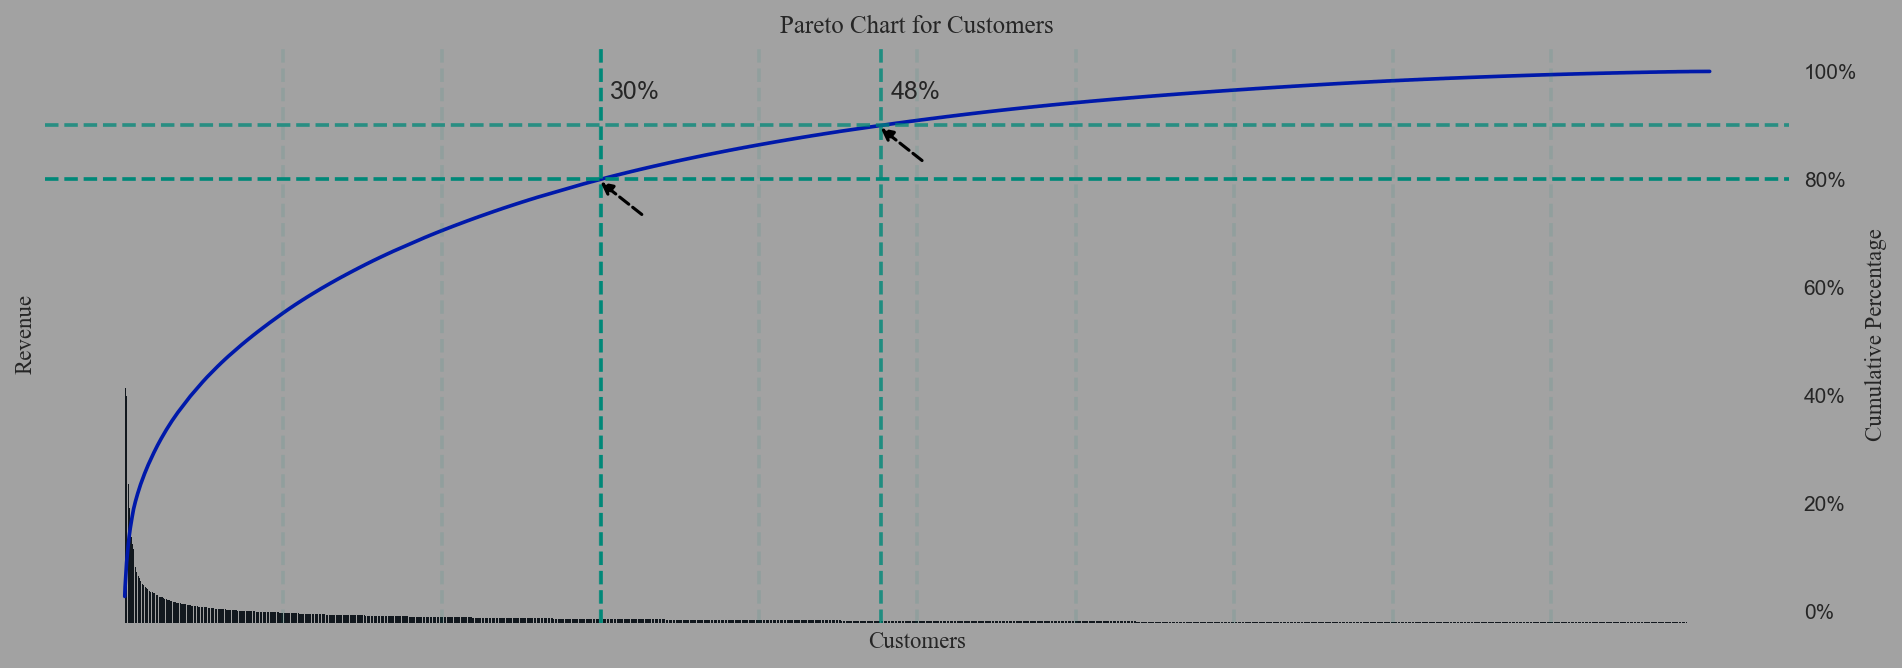

In [67]:
create_pareto_plot(customer_price, 'CustomerID', 'TotalPrice', log =False)

We can also plot it in log scale. It help us for better visualization.

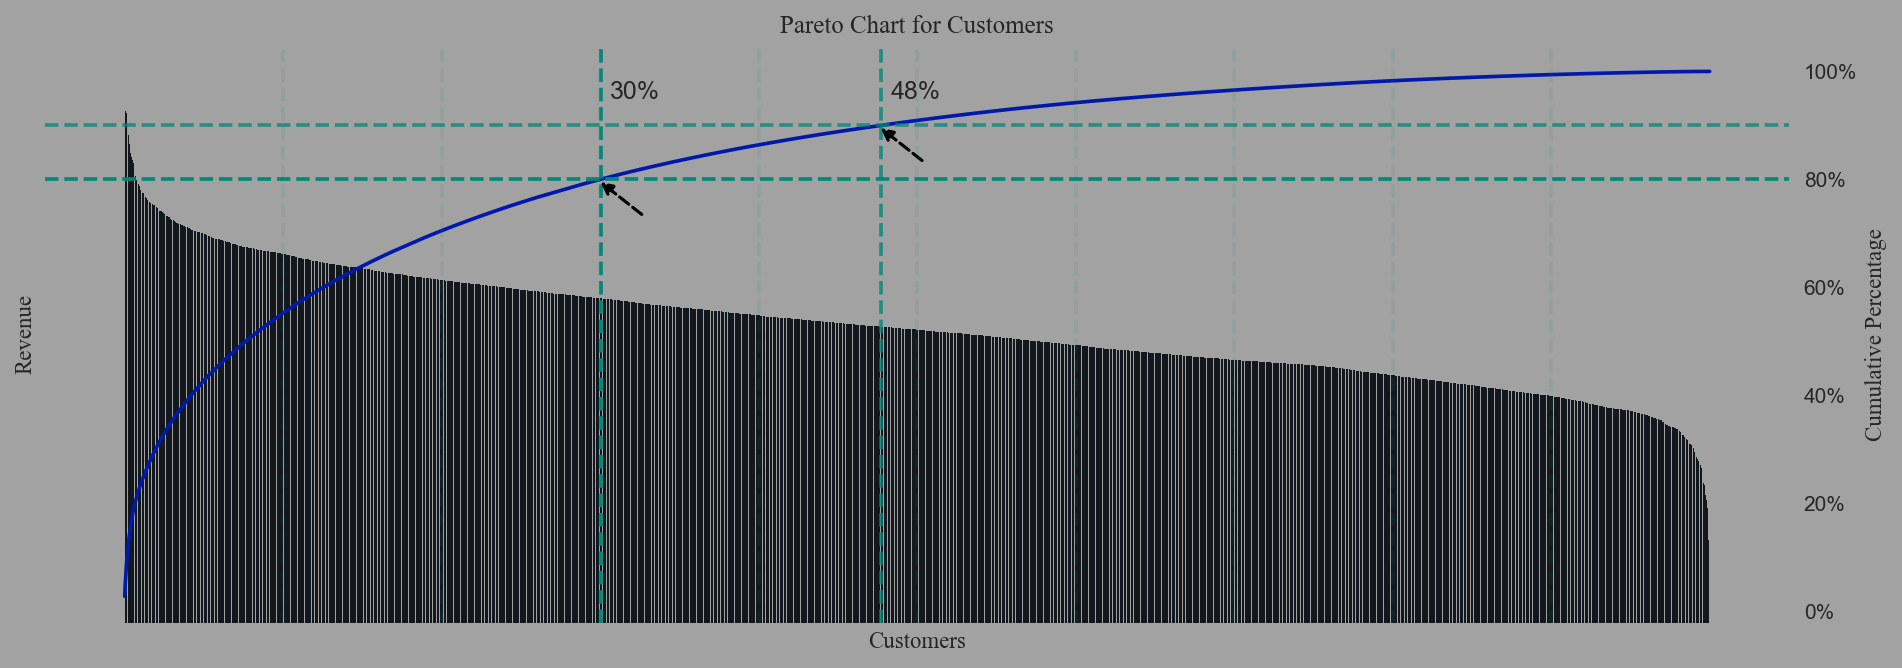

In [68]:
create_pareto_plot(customer_price, 'CustomerID','TotalPrice', log =True)

We, let's interpret these two charts. Actually, we don't need to write a lot of things.
We can see that 80% of company's revenue comes from top 30% of customers.

Also, 90% of company revenue comes from top 48% of customers.

<a id='section-three-two'></a>

# 3.2) Pareto Chart For Products

In [70]:
item_price = prepare_pareto_data(df, 'StockCode', 'TotalPrice')
item_price.head(10)

,TotalPrice,CumulativePercentage
StockCode,,
22423,132100.75,1.83
85123A,68282.78,2.78
47566,61166.83,3.63
85099B,57382.08,4.42
POST,42213.27,5.01
79321,37464.27,5.53
84879,37428.74,6.05
22086,35337.23,6.54
23298,31210.55,6.97


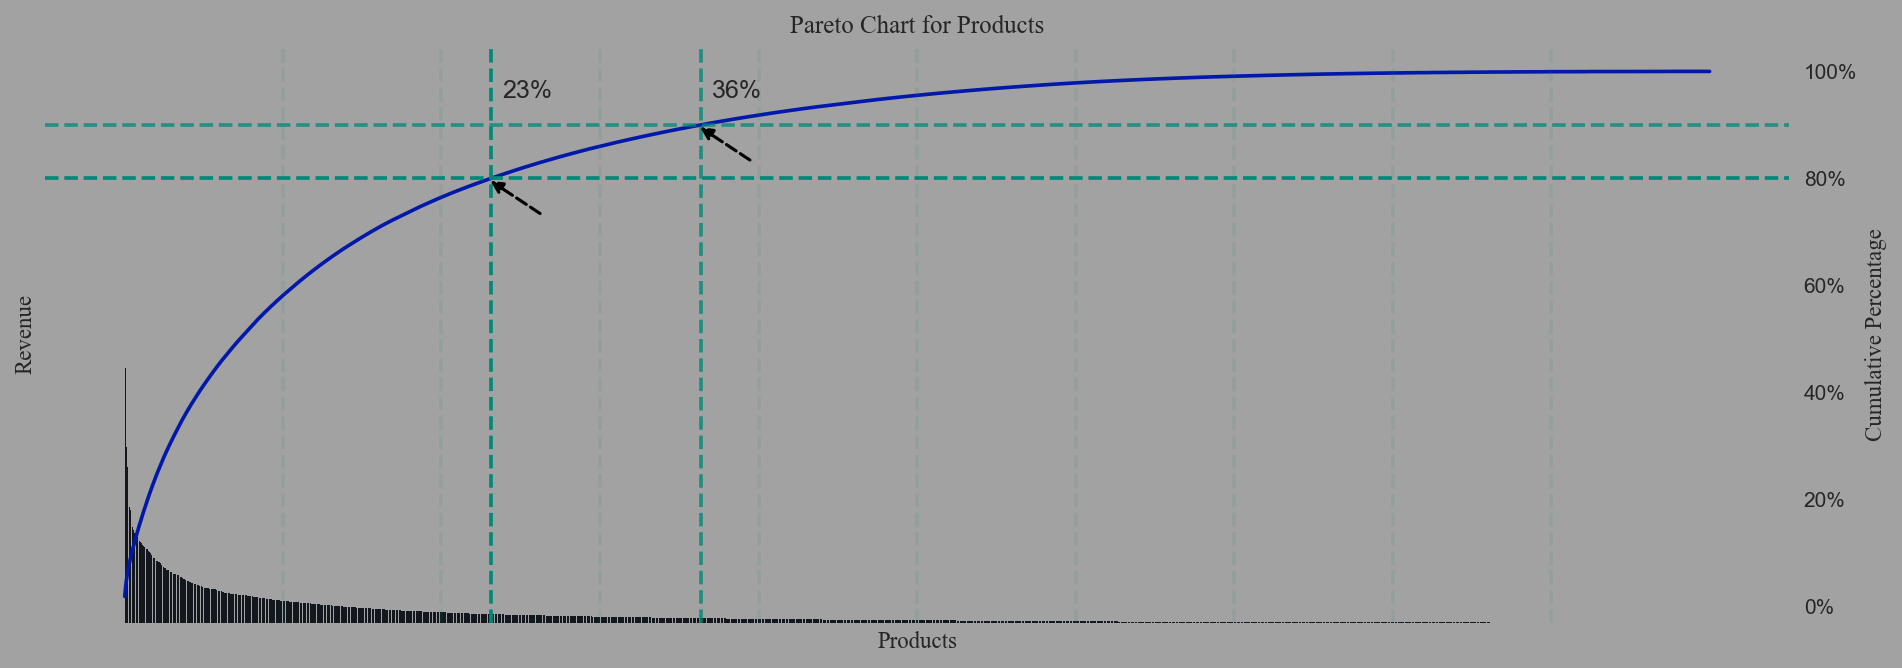

In [71]:
create_pareto_plot(item_price, 'StockCode', 'TotalPrice', log =False)


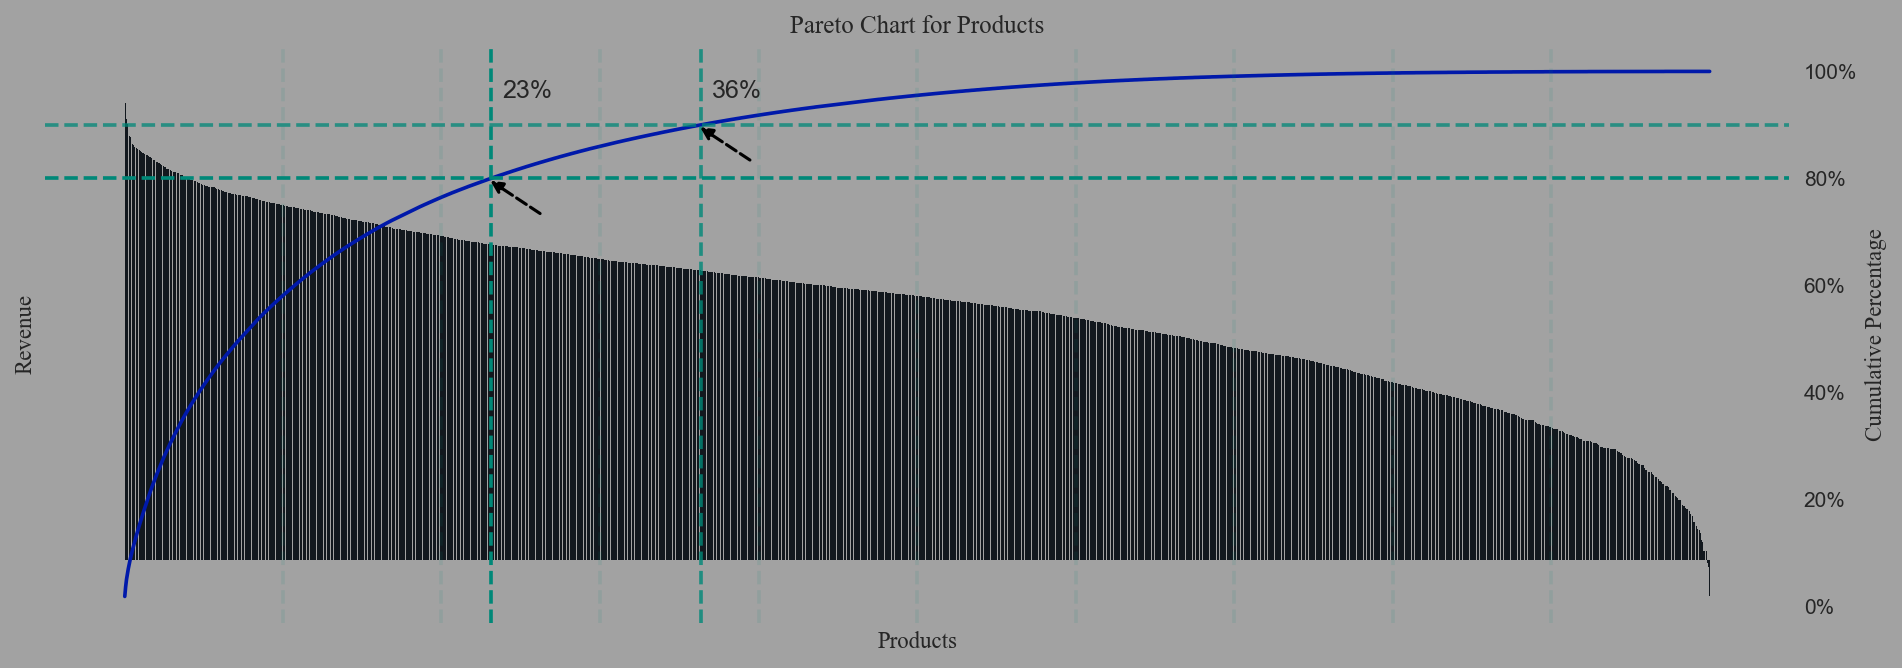

In [73]:
create_pareto_plot(item_price, 'StockCode','TotalPrice')

We can see that 80% company's revenue comes from top 23% of products that have most revenue.

Also, 90% of company revenues comes from 36% of products that have most revenue.

Maybe, if the company reduce by half variety of items, revnue couldnt decrease significantly.

In [75]:
top_customers = customer_price[customer_price.CumulativePercentage <=80].index.tolist()

products_for_top_customers =df[df.CustomerID.isin(top_customers)].Description.drop_duplicates().values.tolist()
products_for_other_customers =df[~df.CustomerID.isin(top_customers)].Description.drop_duplicates().values.tolist()

# 4) RFM Analysis

Recency, frequency, monetary value is a marketing analysis tool used to identify a company's or an organization's best customers by using certain measures. The RFM model is based on three quantitative factors:

**Recency**: How recently a customer has made a purchase

**Frequency**: How often a customer makes a purchase

**Monetary** Value: How much money a customer spends on purchases

RFM analysis numerically ranks a customer in each of these three categories, generally on a scale of 1 to 5 (the higher the number, the better the result). The "best" customer would receive a top score in every category.


*https://www.investopedia.com/terms/r/rfm-recency-frequency-monetary-value.asp

![](https://d35fo82fjcw0y8.cloudfront.net/2018/03/01013508/Incontent_image.png)

*https://clevertap.com/blog/rfm-analysis/

Let's performance RFM Analysis on our data.

<a id='section_four_one'></a>

# 4.1) Preparing RFM Table

In [76]:
print("Min date : {} \n Max date: {}".format(df.InvoiceDate.min(), df.InvoiceDate.max()))

Min date : 2010-12-01 08:26:00 
 Max date: 2011-12-09 12:50:00


In [78]:
last_day = df.InvoiceDate.max() + dt.timedelta(days =1)


In [81]:
rfm_table = df.groupby('CustomerID').agg({"InvoiceDate": lambda x: (last_day - x.max()).days,
                                        "InvoiceNo": "nunique",
                                        'TotalPrice': 'sum'})
rfm_table.rename(columns = {'InvoiceDate': 'Recency',
                           "InvoiceNo": 'Frequency',
                           'TotalPrice': 'Monetary'}, inplace =True)
rfm_table.head()

,Recency,Frequency,Monetary
CustomerID,,,
12347.0,2,7,4060.40
12348.0,75,4,1437.24
12349.0,19,1,1417.60
12350.0,310,1,294.40
12352.0,36,7,1385.74


In [88]:
r_labels = range(5, 0, -1)
fm_labels = range(1, 6)

rfm_table["R"] = pd.qcut(rfm_table["Recency"], 5, labels = r_labels)
rfm_table["F"] = pd.qcut(rfm_table["Frequency"].rank(method = 'first'), 5, labels = fm_labels)
rfm_table["M"] = pd.qcut(rfm_table["Monetary"], 5, labels = fm_labels)

rfm_table.head()

,Recency,Frequency,Monetary,R,F,M
CustomerID,,,,,,
12347.0,2,7,4060.40,5,5,5
12348.0,75,4,1437.24,2,4,4
12349.0,19,1,1417.60,4,1,4
12350.0,310,1,294.40,1,1,2
12352.0,36,7,1385.74,3,5,4


In [89]:
rfm_table["RFM_Segment"] = rfm_table["R"].astype(str) + rfm_table["F"].astype(str) + rfm_table["M"].astype(str)
rfm_table["RFM_Score"] = rfm_table[["R", "F", "M"]].sum(axis = 1)

rfm_table.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score
CustomerID,,,,,,,,
12347.0,2,7,4060.40,5,5,5,555,15
12348.0,75,4,1437.24,2,4,4,244,10
12349.0,19,1,1417.60,4,1,4,414,9
12350.0,310,1,294.40,1,1,2,112,4
12352.0,36,7,1385.74,3,5,4,354,12


**Champions**: Bought recently, buy often and spend the most

**Loyal customers**: Buy on a regular basis. Responsive to promotions.

**Potential loyalist**: Recent customers with average frequency.

**Recent customers**: Bought most recently, but not often.

**Promising**: Recent shoppers, but haven’t spent much.

**Needs attention**: Above average recency, frequency and monetary values. May not have bought very recently though.

**About to sleep**: Below average recency and frequency. Will lose them if not reactivated.

**At risk**: Some time since they’ve purchased. Need to bring them back!

**Can’t lose them**: Used to purchase frequently but haven’t returned for a long time.

**Hibernating**: Last purchase was long back and low number of orders. May be lost.

*https://futurice.com/blog/know-your-customers-with-rfm

I don't know is it right source of below segmentation map dict, but I found that code here.
https://guillaume-martin.github.io/rfm-segmentation-with-python.html

In [93]:
segt_map = {
    r'[1-2][1-2]': 'Hibernating',
    r'[1-2][3-4]': 'At-Risk',
    r'[1-2]5': 'Cannot lose them',
    r'3[1-2]': 'About To Sleep',
    r'33': 'Need Attention',
    r'[3-4][4-5]': 'Loyal Customers',
    r'41': 'Promising',
    r'51': 'New Customers',
    r'[4-5][2-3]': 'Potential Loyalists',
    r'5[4-5]': 'Champions'
}
rfm_table['Segment'] =rfm_table['R'].astype(str) + rfm_table['F'].astype(str) 
rfm_table['Segment'] = rfm_table['Segment'].replace(segt_map, regex =True)
rfm_table.head()

,Recency,Frequency,Monetary,R,F,M,RFM_Segment,RFM_Score,Segment
CustomerID,,,,,,,,,
12347.0,2,7,4060.40,5,5,5,555,15,Champions
12348.0,75,4,1437.24,2,4,4,244,10,At-Risk
12349.0,19,1,1417.60,4,1,4,414,9,Promising
12350.0,310,1,294.40,1,1,2,112,4,Hibernating
12352.0,36,7,1385.74,3,5,4,354,12,Loyal Customers


<a id="section-four-three"></a>

# 4.3) Visualizing RFM Grid

![](https://www.wigzo.com/blog/wp-content/uploads/2021/06/RFM-Analysis.jpg)

*https://www.wigzo.com/blog/wp-content/uploads/2021/06/RFM-Analysis.jpg

Well, I'm surprised name plot above graph

I wrote these codes for visualize above RFM grid

In [95]:
rfm_coordinates = {"Champions": [3, 5, 0.8, 1],
                   "Loyal Customers": [3, 5, 0.4, 0.8],
                   "Cannot lose them": [4, 5, 0, 0.4],
                   "At-Risk": [2, 4, 0, 0.4],
                   "Hibernating": [0, 2, 0, 0.4],
                   "About To Sleep": [0, 2, 0.4, 0.6],
                   "Promising": [0, 1, 0.6, 0.8],
                   "New Customers": [0, 1, 0.8, 1],
                   "Potential Loyalists": [1, 3, 0.6, 1],
                   "Need Attention": [2, 3, 0.4, 0.6]}

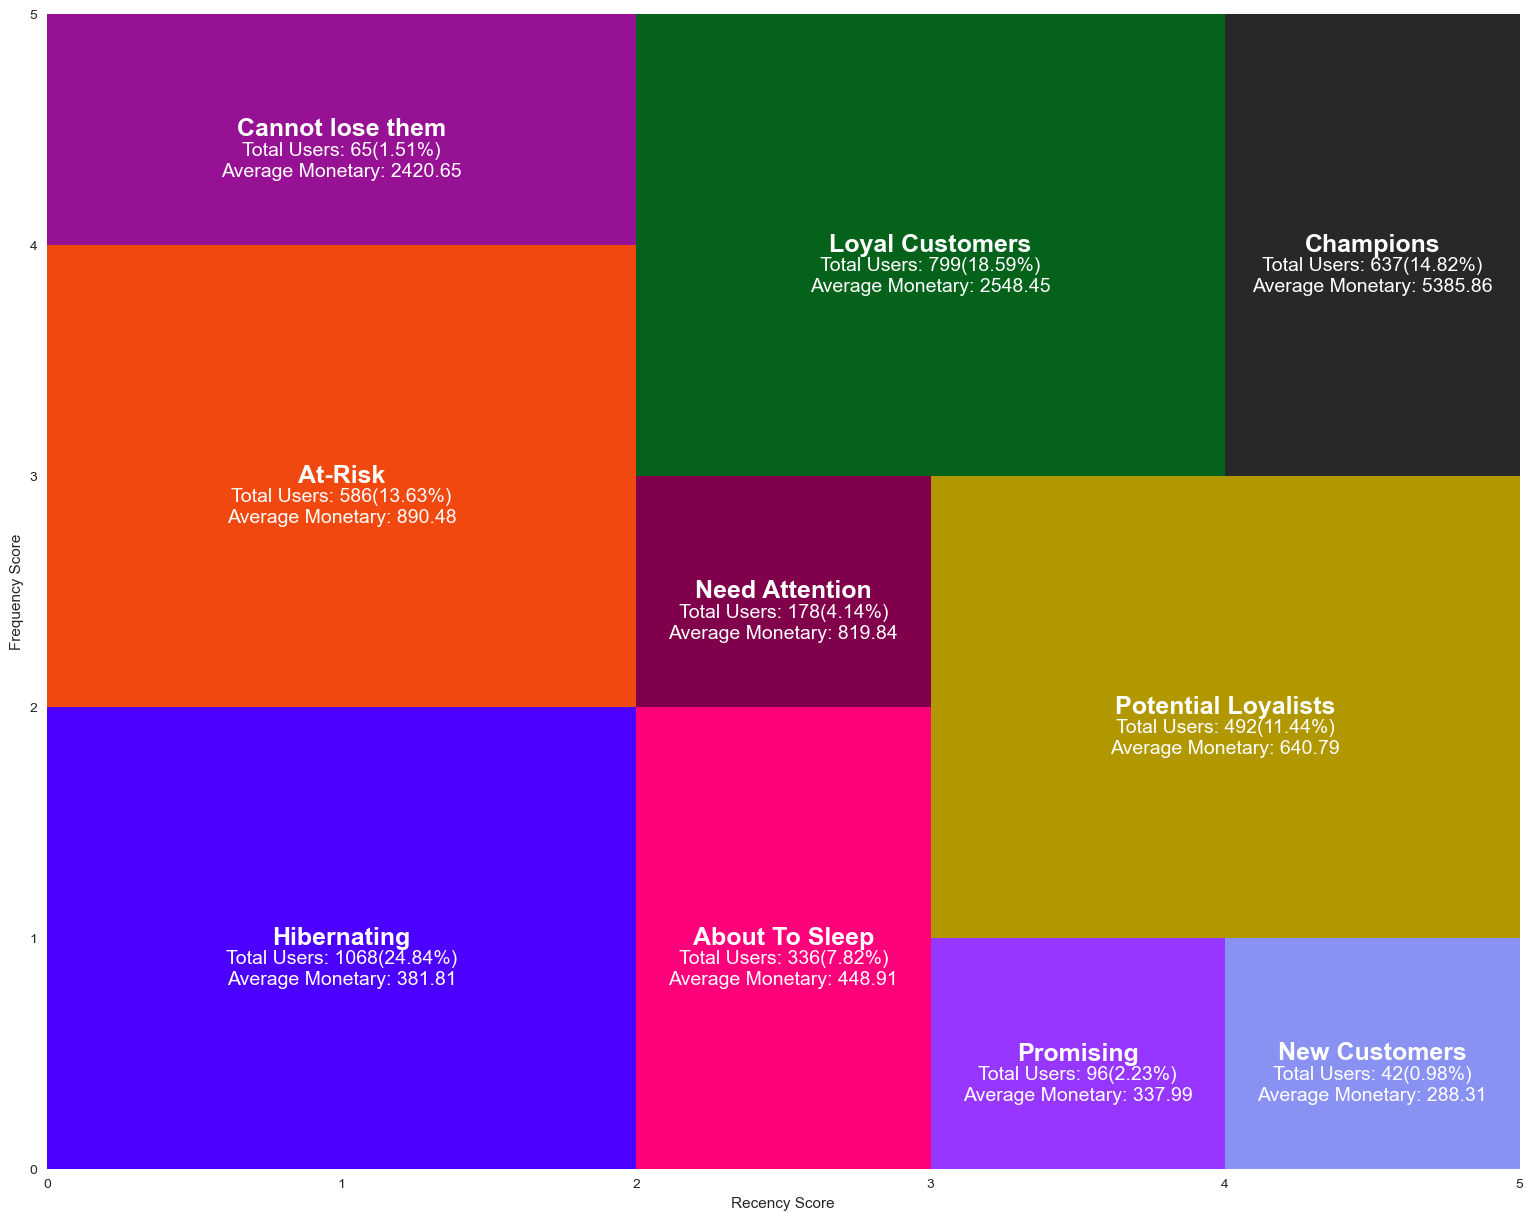

In [96]:
fig, ax = plt.subplots(figsize = (19, 15))

ax.set_xlim([0, 5])
ax.set_ylim([0, 5])

plt.rcParams["axes.facecolor"] = "white"
palette = ["#282828", "#04621B", "#971194", "#F1480F",  "#4C00FF", 
           "#FF007B", "#9736FF", "#8992F3", "#B29800", "#80004C"]

for key, color in zip(rfm_coordinates.keys(), palette[:10]):
    
    coordinates = rfm_coordinates[key]
    ymin, ymax, xmin, xmax = coordinates[0], coordinates[1], coordinates[2], coordinates[3]
    
    ax.axhspan(ymin = ymin, ymax = ymax, xmin = xmin, xmax = xmax, facecolor = color)
    
    users = rfm_table[rfm_table.Segment == key].shape[0]
    users_percentage = (rfm_table[rfm_table.Segment == key].shape[0] / rfm_table.shape[0]) * 100
    avg_monetary = rfm_table[rfm_table.Segment == key]["Monetary"].mean()
    
    user_txt = "\n\nTotal Users: " + str(users) + "(" +  str(round(users_percentage, 2)) + "%)"
    monetary_txt = "\n\n\n\nAverage Monetary: " + str(round(avg_monetary, 2))
    
    x = 5 * (xmin + xmax) / 2
    y = (ymin + ymax) / 2
    
    plt.text(x = x, y = y, s = key, ha = "center", va = "center", fontsize = 18, color = "white", fontweight = "bold")
    plt.text(x = x, y = y, s = user_txt, ha = "center", va = "center", fontsize = 14, color = "white")    
    plt.text(x = x, y = y, s = monetary_txt, ha = "center", va = "center", fontsize = 14, color = "white")    
    
    ax.set_xlabel("Recency Score")
    ax.set_ylabel("Frequency Score")
    
sns.despine(left = True, bottom = True)
plt.show()

<a id="section-four-four"></a>

# 4.4) Visualizing RFM Segments

We can show table of descriptive statistics for RFM segments, but it is not best way. Using data visualization skills and creating great plots as important as finding great results.

In [98]:
rfm_table2 = rfm_table.reset_index()

rfm_monetary_size = rfm_table2.groupby("Segment").agg({"Monetary": "mean",
                                                       "CustomerID": "nunique"})

rfm_monetary_size.rename(columns = {"Monetary": "MeanMonetary", "CustomerID": "CustomerCount"}, inplace = True)
rfm_monetary_size = rfm_monetary_size.sort_values("MeanMonetary", ascending = False)

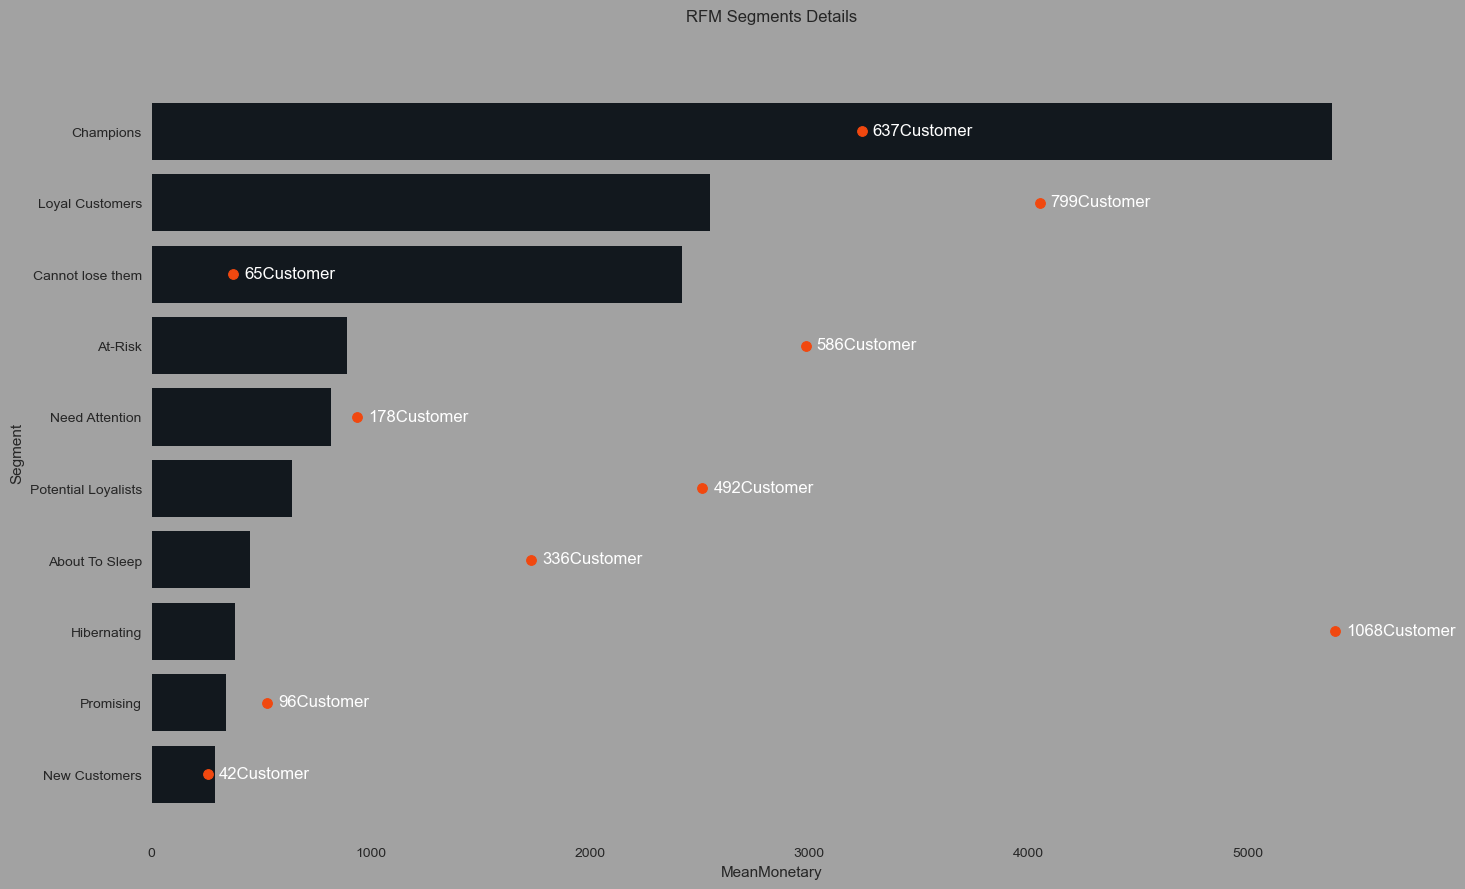

In [105]:
plt.rcParams['axes.facecolor'] = '#A2A2A2'
fig, ax = plt.subplots(figsize =(16,10), facecolor ='#A2A2A2')

sns.barplot(x =rfm_monetary_size.MeanMonetary, y =rfm_monetary_size.index, ax=ax, color='#101820')
ax2 = ax.twiny()
sns.lineplot( x = rfm_monetary_size.CustomerCount, y =rfm_monetary_size.index, ax=ax2, marker='o',linewidth =0,
            color ='#F1480F', markeredgecolor ='#F1480F')

ax2.axis("off")

for y, x in list(enumerate(rfm_monetary_size.CustomerCount)):
    ax2.text(x+10 , y+ 0.05, str(x) + 'Customer', color ='white', fontweight ='normal')

plt.title("RFM Segments Details")
sns.despine(left = True, bottom = True, top = True)
plt.show()

In [110]:
rfm =rfm_table2.groupby("Segment").agg({'CustomerID': 'nunique',
                                       'Recency':'mean',
                                       'Frequency':'mean',
                                       'Monetary':'mean'})
rfm.rename(columns = {'CustomerID': 'Segment Size'}, inplace =True)

cm =sns.light_palette("#A2A2A2", as_cmap =True)

rfm.T.style.background_gradient(cmap =cm, axis =1)\
.set_precision(2)\
.highlight_min(axis = 1, color = "#195190")\
.highlight_max(axis =1, color ='#D60000')

C:\Users\DeLL\AppData\Local\Temp\ipykernel_26476\478659765.py:9: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  rfm.T.style.background_gradient(cmap =cm, axis =1)\


Segment,About To Sleep,At-Risk,Cannot lose them,Champions,Hibernating,Loyal Customers,Need Attention,New Customers,Potential Loyalists,Promising
Segment Size,336.00,586.00,65.00,637.00,1068.00,799.00,178.00,42.00,492.00,96.00
Recency,53.01,152.73,132.29,6.03,216.70,33.31,51.99,7.17,17.18,23.55
Frequency,1.15,2.85,8.28,12.07,1.10,6.41,2.30,1.00,1.99,1.00
Monetary,448.91,890.48,2420.65,5385.86,381.81,2548.45,819.84,288.31,640.79,337.99


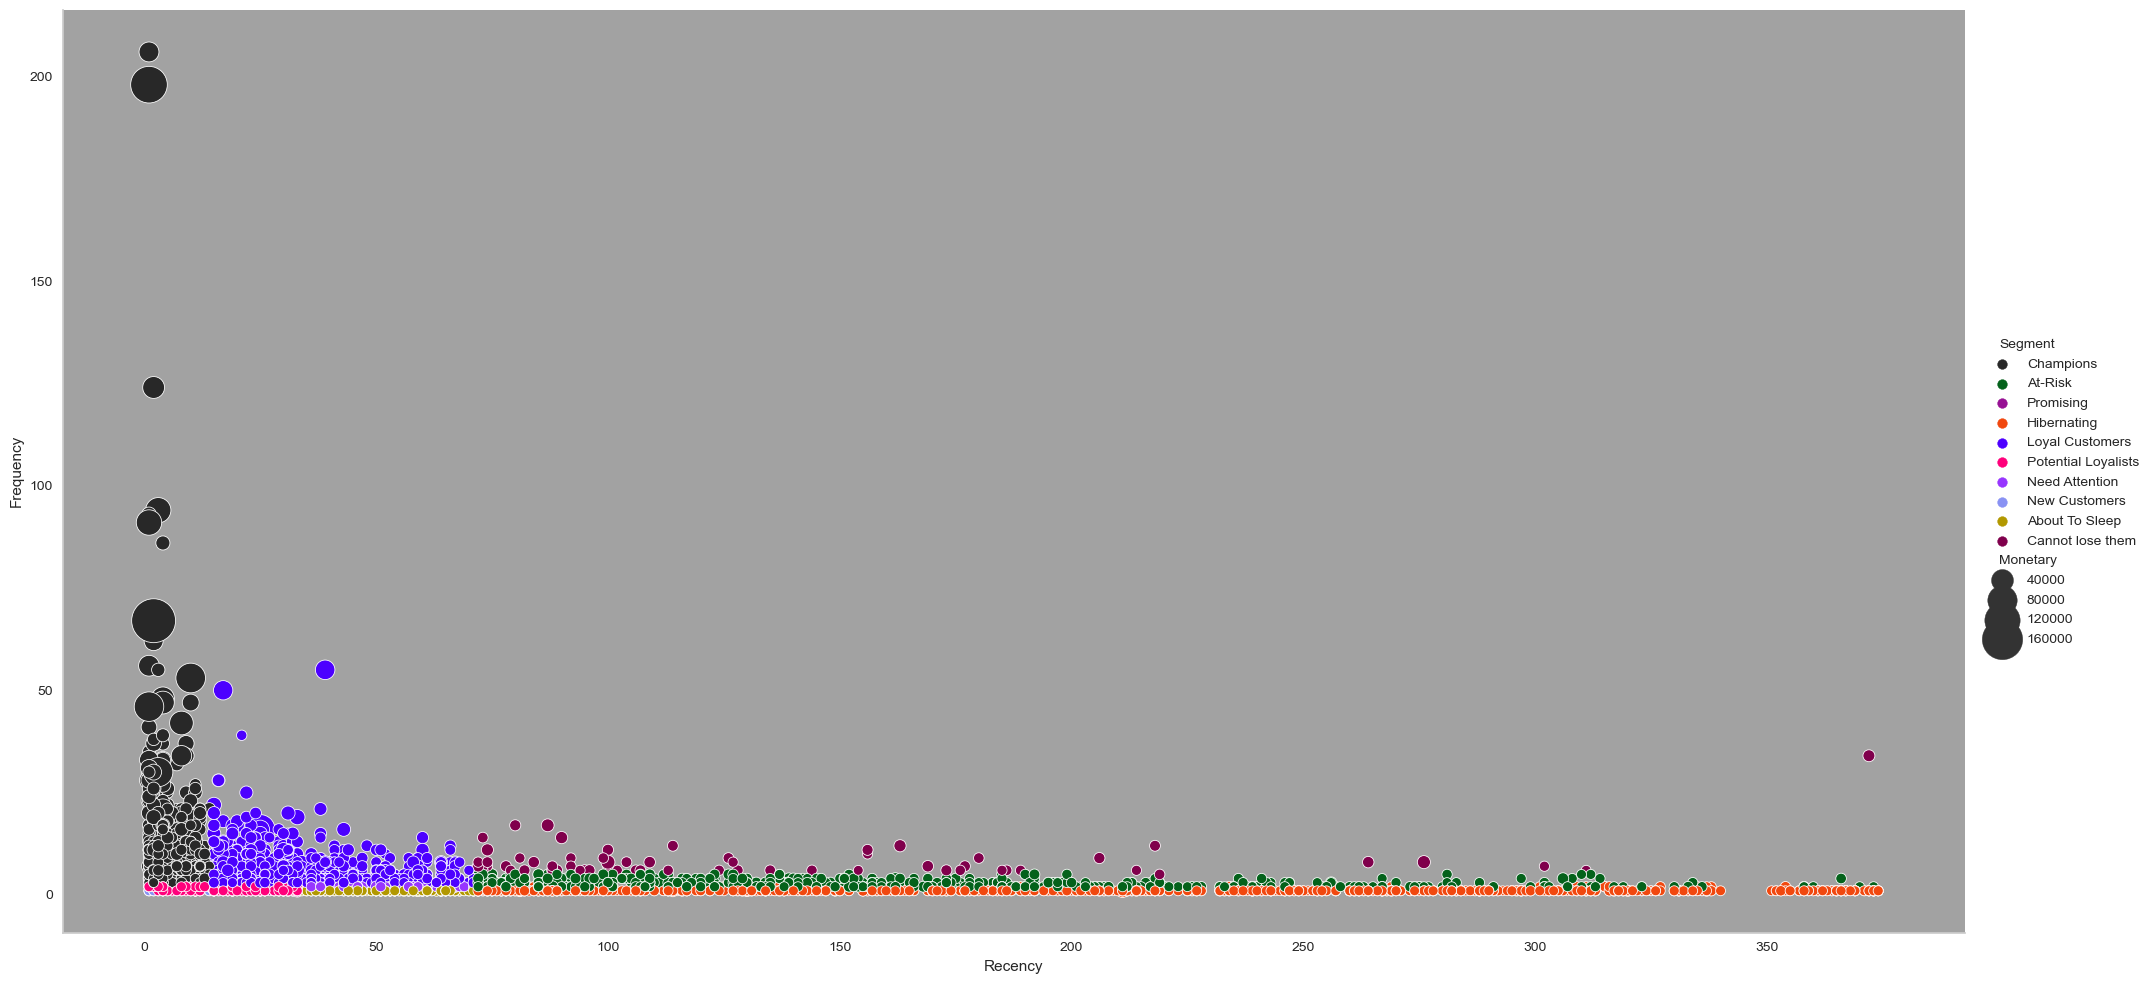

In [112]:
plt.rcParams['axes.facecolor'] ='#A2A2A2'
plt.rcParams['axes.grid'] = False

sns.relplot( x ='Recency', y ='Frequency', hue ='Segment', size ='Monetary', data =rfm_table2, palette = palette,
            height = 10 , aspect = 2, sizes = (50,1000))
plt.show()

In [114]:
monetary_per_segment = (rfm_table2.groupby("Segment")["Monetary"].sum() /\
                        rfm_table2.groupby("Segment")["Monetary"].sum().sum()).sort_values(ascending = False)

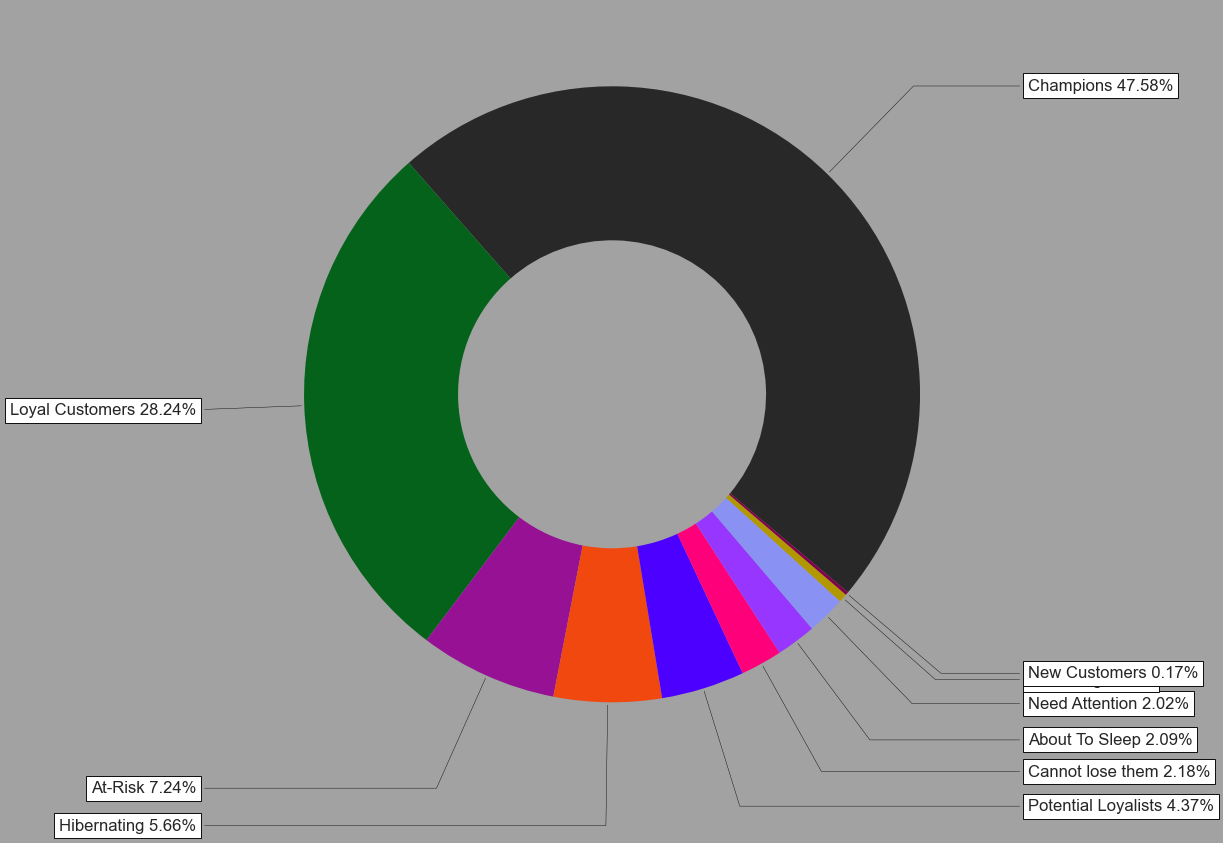

In [115]:
fig, ax = plt.subplots(figsize = (10, 10), facecolor = "#A2A2A2")

wedges, texts = ax.pie(monetary_per_segment.values, wedgeprops=dict(width=0.5), 
                       startangle=-40, normalize=False, colors = palette)

bbox_props = dict(boxstyle="square,pad=0.3", fc="w", ec="k", lw=0.72)
kw = dict(arrowprops=dict(arrowstyle="-"),
          bbox=bbox_props, zorder=0, va="center")

for i, p in enumerate(wedges):
    ang = (p.theta2 - p.theta1)/2. + p.theta1
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    horizontalalignment = {-1: "right", 1: "left"}[int(np.sign(x))]
    connectionstyle = "angle,angleA=0,angleB={}".format(ang)
    kw["arrowprops"].update({"connectionstyle": connectionstyle})
    ax.annotate(monetary_per_segment.index[i] + " " + str(round(monetary_per_segment[i] * 100, 2)) + "%", xy=(x, y), 
                xytext=(1.35*np.sign(x), 1.4*y),horizontalalignment=horizontalalignment, **kw)
plt.show()

47.5% of total revenue comes from 'Champions' segment, and 28% of total revenue comes from "Loyal Customers" segment. These two segments have 75% of company's total revenue. 

In [119]:
rfm_clustering = rfm_table2[['Recency', 'Frequency','Monetary', 'Segment']]

for col in ['Recency', 'Frequency', 'Monetary']:
    
    scaler = StandardScaler()
    rfm_clustering[col] = np.log(rfm_clustering[col])
    rfm_clustering[col] = scaler.fit_transform(rfm_clustering[col].values.reshape(-1,1))

rfm_melted = pd.melt(rfm_clustering, id_vars ='Segment', value_vars=['Recency', 'Frequency', 'Monetary'],
                    var_name = 'RFM', value_name = 'Value')

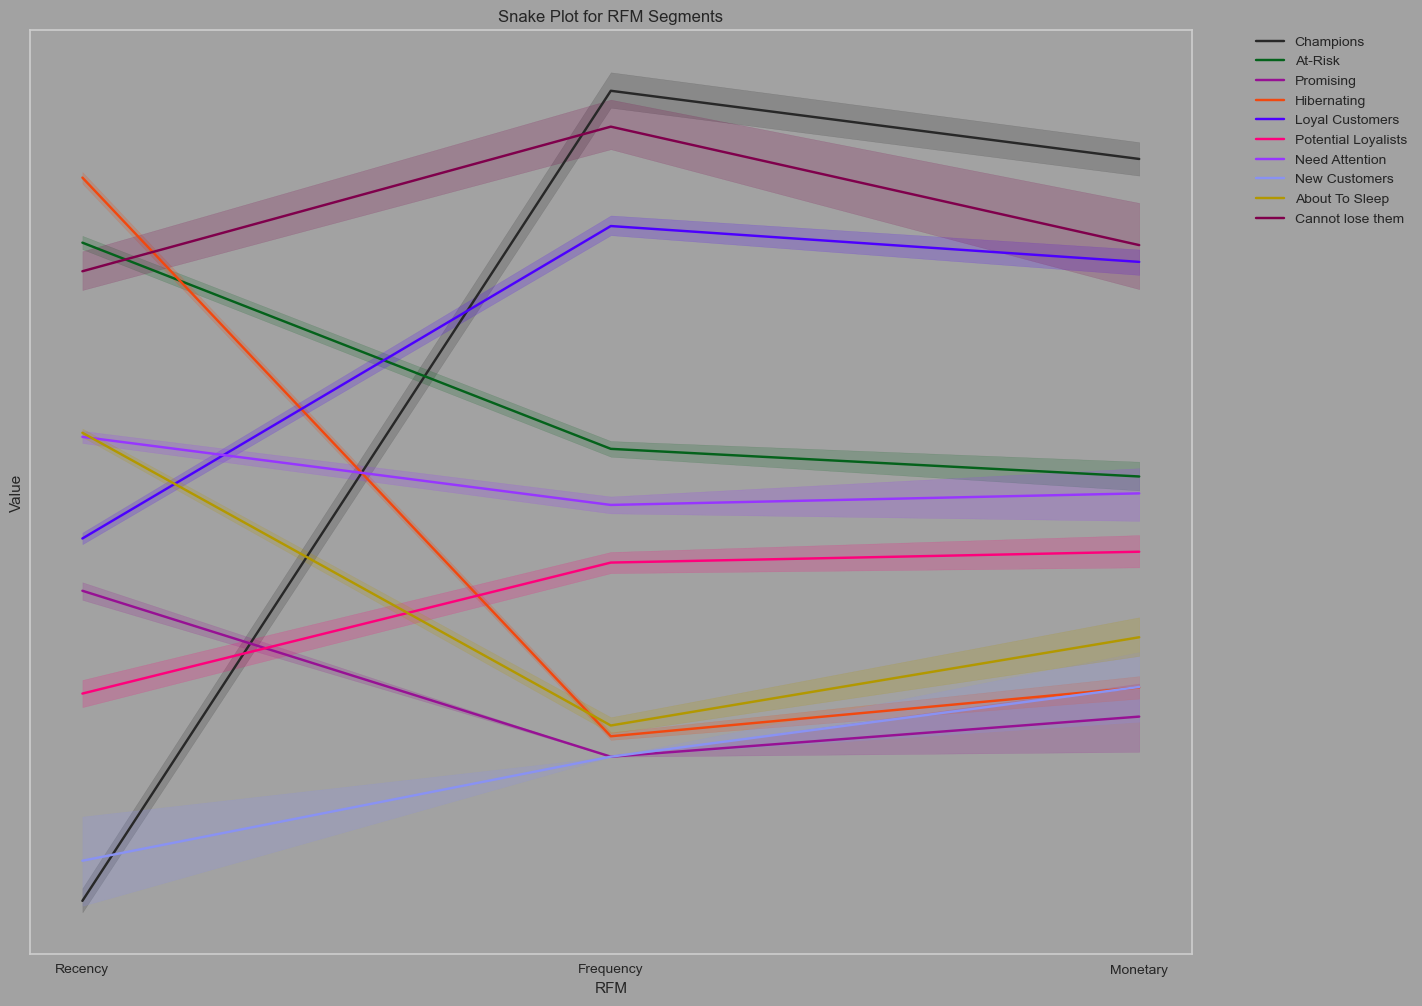

In [121]:
fig, ax = plt.subplots(figsize =(15,12), facecolor ="#A2A2A2")
ax.set_facecolor('#A2A2A2')

sns.lineplot(x='RFM', y ='Value', hue ='Segment', data = rfm_melted, palette = palette)
ax.legend(bbox_to_anchor = (1.05, 1), loc =2,borderaxespad = 0.)
ax.set_yticks([])
ax.set_title("Snake Plot for RFM Segments")
plt.show()

<a id='section-four-five'><a/>
# 4.5) Customer Segmentation with using RFM Metrics

C:\Users\DeLL\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\DeLL\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\DeLL\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\DeLL\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\Users\DeLL\anaconda3\lib\site-packages\sklearn\cluster\_k

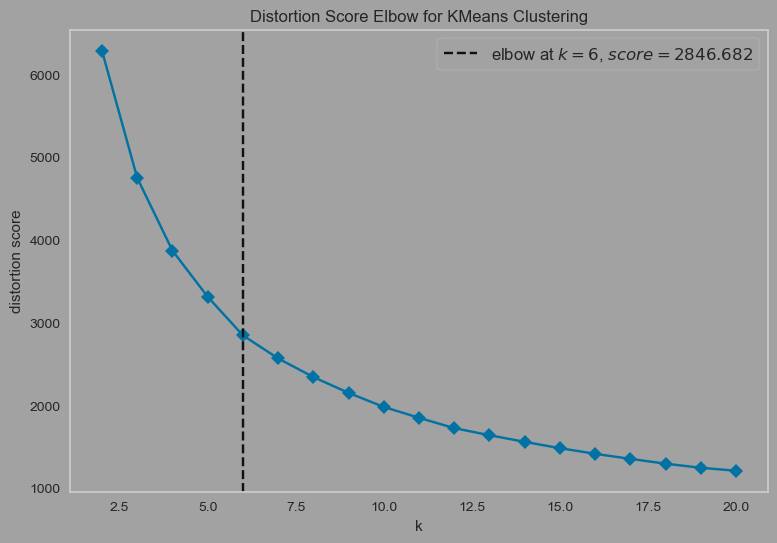

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [124]:
features = ["Recency", "Frequency", "Monetary"]

kmeans_ = KMeans(init = "k-means++", random_state = 42)

fig, ax = plt.subplots(figsize = (9, 6), facecolor = "#A2A2A2")
ax.set_facecolor("#A2A2A2")
ax.grid(False)

visualizer = KElbowVisualizer(kmeans_, k = (2, 21), timings = False)

visualizer.fit(rfm_clustering[features]) 
visualizer.show()

C:\Users\DeLL\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


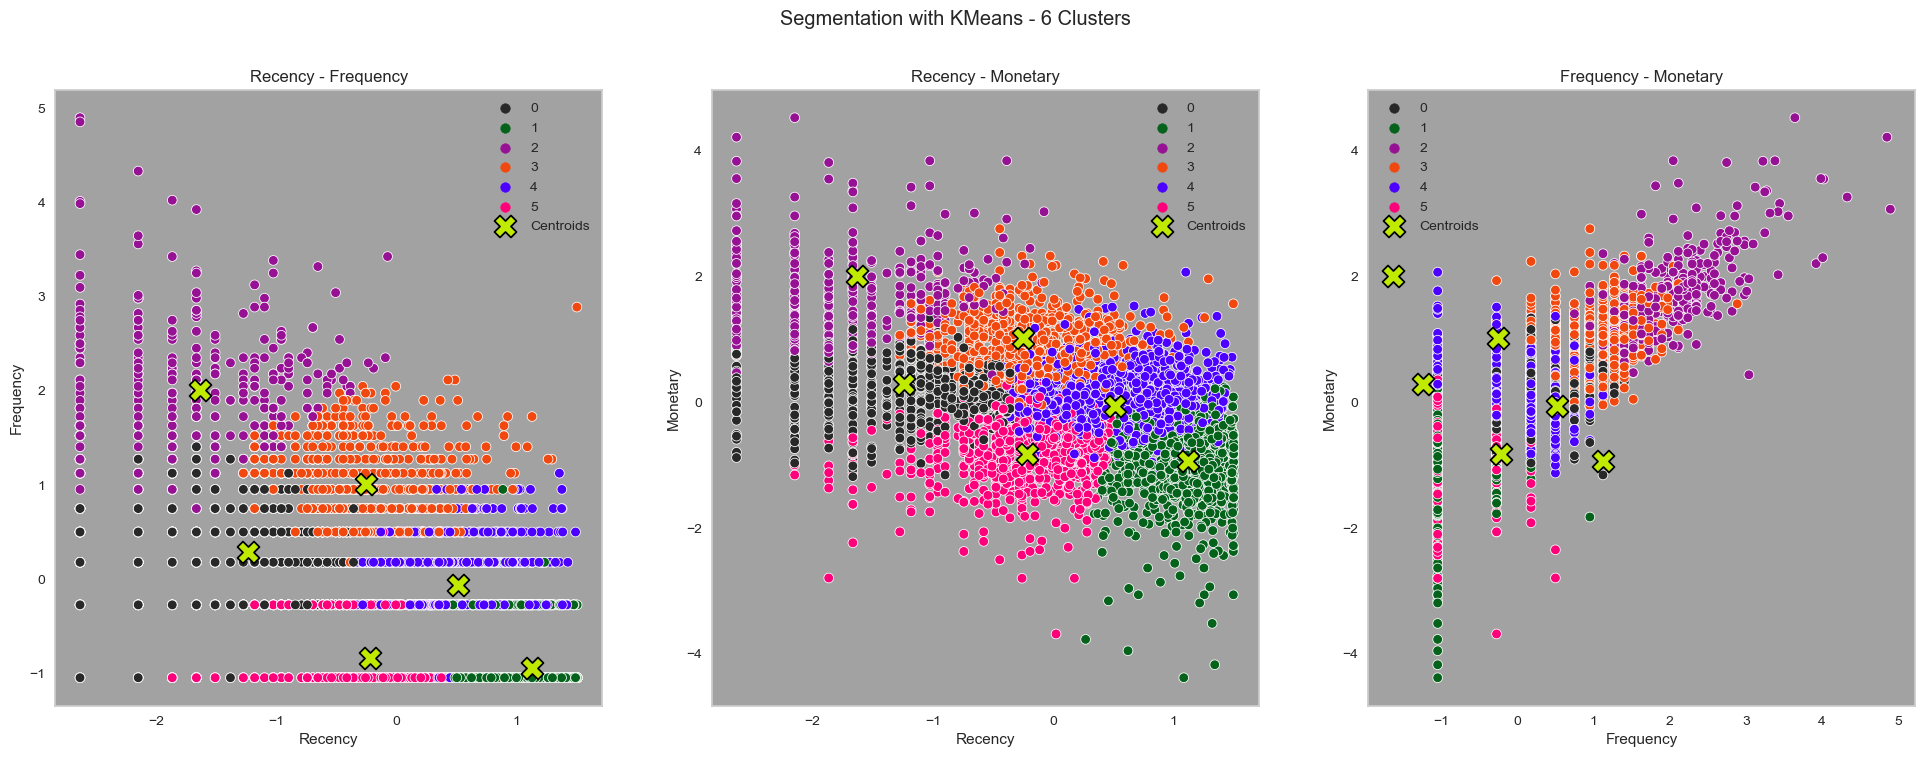

In [125]:
kmeans = KMeans(n_clusters = 6, random_state = 42) 
kmeans.fit(rfm_clustering[features])
cluster = kmeans.labels_

fig, axes = plt.subplots(1, 3, figsize = (24, 8))

for i, feature in list(enumerate(combinations(["Recency", "Frequency", "Monetary"], 2))):

    sns.scatterplot(x = rfm_clustering[feature[0]], y = rfm_clustering[feature[1]], hue = cluster, 
                    palette = palette[: len(set(cluster))], ax = axes[i]).set_title(feature[0] + " - " + feature[1])

    sns.scatterplot(x = kmeans.cluster_centers_[:, 0], y = kmeans.cluster_centers_[:, 1],
                    s = 250, color = '#C0EB00', label = 'Centroids', marker = "X", ax = axes[i], edgecolor = "black")

plt.suptitle("Segmentation with KMeans - 6 Clusters")
for ax in axes:
    ax.set_facecolor("#A2A2A2")
    ax.grid(False)
    
plt.show()

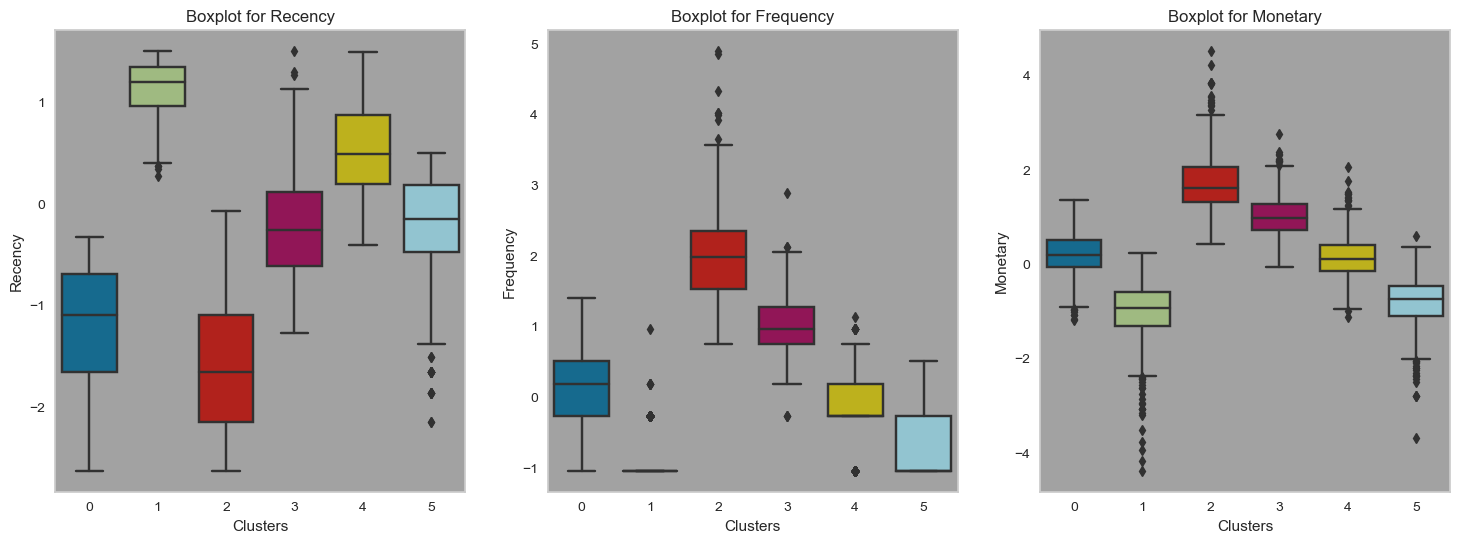

In [126]:
fig, axes = plt.subplots(1, 3, figsize = (18, 6))

for ax in axes:
    ax.set_facecolor("#A2A2A2")
    ax.set_xlabel("Clusters")
    
sns.boxplot(x = cluster, y = "Recency", data = rfm_clustering, ax = axes[0]).set_title("Boxplot for Recency")
sns.boxplot(x = cluster, y = "Frequency", data = rfm_clustering, ax = axes[1]).set_title("Boxplot for Frequency")
sns.boxplot(x = cluster, y = "Monetary", data = rfm_clustering, ax = axes[2]).set_title("Boxplot for Monetary")

plt.show()

In [127]:
plt.rcdefaults()